Aggregation of all dialogues -(movie genre)

In [1]:
import pandas as pd
import re

# Parse movie_titles_metadata.txt
def load_movie_titles(filepath):
    data = []
    with open(filepath, 'r', encoding='ISO-8859-1') as f:
        for line in f:
            parts = re.split(r'\s*\+\+\+\$\+\+\+\s*', line.strip())
            if len(parts) >= 6:
                movie_id, movie_title, year, rating, votes, genres = parts[:6]
                genres = re.sub(r"[\[\]']", '', genres).replace(',', ', ').strip()
                data.append([movie_id.strip(), movie_title.strip(), genres])
    return pd.DataFrame(data, columns=['movie_id', 'movie_title', 'genres'])

# Parse movie_characters_metadata.txt
def load_characters(filepath):
    data = []
    with open(filepath, 'r', encoding='ISO-8859-1') as f:
        for line in f:
            parts = re.split(r'\s*\+\+\+\$\+\+\+\s*', line.strip())
            if len(parts) >= 5:
                character_id, character_name, movie_id, gender, position = parts[:5]
                data.append([character_id.strip(), character_name.strip(), movie_id.strip()])
    return pd.DataFrame(data, columns=['character_id', 'character_name', 'movie_id'])

# Parse movie_lines.txt
def load_lines(filepath):
    data = []
    with open(filepath, 'r', encoding='ISO-8859-1') as f:
        for line in f:
            parts = re.split(r'\s*\+\+\+\$\+\+\+\s*', line.strip())
            if len(parts) >= 5:
                line_id, character_id, movie_id, character_name, text = parts[:5]
                data.append([character_id.strip(), character_name.strip(), movie_id.strip(), text.strip()])
    return pd.DataFrame(data, columns=['character_id', 'character_name', 'movie_id', 'text'])

# Load all data
movies = load_movie_titles('cornell movie-dialogs corpus/movie_titles_metadata.txt')
characters = load_characters('cornell movie-dialogs corpus/movie_characters_metadata.txt')
lines = load_lines('cornell movie-dialogs corpus/movie_lines.txt')

# Aggregate all lines for each character
agg_lines = lines.groupby('character_id')['text'].apply(lambda x: ' '.join(x)).reset_index()
agg_lines = agg_lines.merge(characters, on='character_id', how='left')
agg_lines = agg_lines.merge(movies, on='movie_id', how='left')

# Final columns: character_name, all_lines, movie_title, genres
agg_lines = agg_lines[['character_name', 'text', 'movie_title', 'genres']]
agg_lines.rename(columns={'text': 'all_lines'}, inplace=True)

# Save to CSV
agg_lines.to_csv('character_dialogues_with_movie_genre.csv', index=False)
print(agg_lines.head())

  character_name                                          all_lines  \
0         BIANCA  They do not! I hope so. Let's go. Okay -- you'...   
1          BRUCE  Just sent 'em through. Never Didn't have you p...   
2         SHARON  Absolutely not. Your daughters went to the pro...   
3            AMY  She died in her sleep three days ago.  It was ...   
4         MCGRAW  Yeah, and I'm gonna be right back at it tomorr...   

                  movie_title                              genres  
0  10 things i hate about you                    comedy,  romance  
1  10 things i hate about you                    comedy,  romance  
2  10 things i hate about you                    comedy,  romance  
3                         8mm          crime,  mystery,  thriller  
4         from dusk till dawn  action,  crime,  horror,  thriller  


Text Cleaning 

In [2]:
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import wordnet
import nltk
from tqdm import tqdm
import numpy as np
import json

# Download required NLTK data with error handling
def download_nltk_data():
    """Download required NLTK data"""
    nltk_downloads = [
        'punkt',
        'stopwords', 
        'wordnet',
        'averaged_perceptron_tagger',
        'omw-1.4'
    ]
    
    print("📦 Downloading NLTK data...")
    for item in nltk_downloads:
        try:
            nltk.download(item, quiet=True)
            print(f"✅ Downloaded {item}")
        except Exception as e:
            print(f"⚠️  Warning: Could not download {item}: {e}")

# Download NLTK data at import
download_nltk_data()

📦 Downloading NLTK data...
✅ Downloaded punkt
✅ Downloaded stopwords
✅ Downloaded wordnet
✅ Downloaded averaged_perceptron_tagger
✅ Downloaded omw-1.4


In [4]:
import pandas as pd
df = pd.read_csv('character_dialogues_with_movie_genre.csv')
print(df.columns)

Index(['character_name', 'all_lines', 'movie_title', 'genres'], dtype='object')


In [10]:
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import wordnet
import nltk
from tqdm import tqdm
import numpy as np
import json


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def clean_surface_level(text):
    """
    Light cleaning that preserves tone and emotional markers
    - Removes stage directions and obvious noise
    - Preserves punctuation, capitalization, contractions
    """
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # Remove stage directions but preserve emotional expressions
    text = re.sub(r'\([^)]*\)|\[[^\]]*\]', '', text)
    
    # Remove excessive special characters but keep emotionally relevant ones
    text = re.sub(r'[^\w\s.,!?\'\-;:]', ' ', text)
    
    # Normalize excessive punctuation (but preserve emphasis)
    text = re.sub(r'([.!?]){3,}', r'\1\1\1', text)  # Max 3 repeated punctuation
    text = re.sub(r'([A-Z])\1{2,}', r'\1\1', text)  # Max 2 repeated caps
    
    # Clean whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def clean_semantic_level(text):
    """
    Semantic cleaning with lemmatization while preserving sentence structure
    - Lemmatizes words for semantic consistency
    - Preserves sentence boundaries and basic punctuation
    """
    if pd.isna(text):
        return ""
    
    lemmatizer = WordNetLemmatizer()
    
    # First apply surface cleaning
    text = clean_surface_level(text)
    
    sentences = sent_tokenize(text)
    processed_sentences = []
    
    for sentence in sentences:
        # Convert to lowercase for processing
        lower_sentence = sentence.lower()
        
        # Tokenize words
        words = word_tokenize(lower_sentence)
        processed_words = []
        
        for word in words:
            if word.isalpha() and len(word) > 1:
                # Lemmatize with proper POS tagging
                pos = get_wordnet_pos(word)
                lemmatized = lemmatizer.lemmatize(word, pos)
                processed_words.append(lemmatized)
            elif word in '.!?,:;':
                # Preserve important punctuation
                processed_words.append(word)
            elif word in ["n't", "'m", "'re", "'ve", "'ll", "'d"]:
                # Preserve contractions for tone
                processed_words.append(word)
        
        if processed_words:
            processed_sentences.append(' '.join(processed_words))
    
    return ' '.join(processed_sentences)

def clean_full_level(text):
    """
    Full cleaning for pure content analysis
    - Removes stopwords
    - Focuses on content words only
    - Best for topic modeling and semantic analysis
    """
    if pd.isna(text):
        return ""
    
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    # Start with semantic cleaning
    text = clean_semantic_level(text)
    
    words = word_tokenize(text.lower())
    content_words = []
    
    for word in words:
        if (word.isalpha() and 
            len(word) > 2 and 
            word not in stop_words):
            # Additional lemmatization to be sure
            pos = get_wordnet_pos(word)
            lemmatized = lemmatizer.lemmatize(word, pos)
            content_words.append(lemmatized)
    
    return ' '.join(content_words)

def extract_dialogue_metadata(original_text):
    """Extract metadata that might be useful for persona analysis"""
    if pd.isna(original_text):
        return {}
    
    original_text = str(original_text)
    metadata = {}
    
    # Emotional intensity markers
    metadata['exclamation_count'] = original_text.count('!')
    metadata['question_count'] = original_text.count('?')
    metadata['caps_words'] = len(re.findall(r'\b[A-Z]{2,}\b', original_text))
    metadata['elongated_words'] = len(re.findall(r'\w*([a-zA-Z])\1{2,}\w*', original_text))
    
    # Contractions (informal speech markers)
    contractions = ["n't", "'m", "'re", "'ve", "'ll", "'d", "gonna", "wanna", "gotta"]
    metadata['contraction_count'] = sum(original_text.lower().count(c) for c in contractions)
    
    # Sentence complexity
    surface_cleaned = clean_surface_level(original_text)
    sentences = sent_tokenize(surface_cleaned)
    if sentences:
        metadata['avg_sentence_length'] = np.mean([len(s.split()) for s in sentences])
        metadata['sentence_count'] = len(sentences)
    else:
        metadata['avg_sentence_length'] = 0
        metadata['sentence_count'] = 0
    
    # Dialogue length
    metadata['original_length'] = len(original_text)
    metadata['word_count'] = len(original_text.split())
    
    return metadata

def process_single_dialogue(text):
    """Process a single dialogue text at all levels"""
    result = {
        'original': str(text) if not pd.isna(text) else "",
        'surface_cleaned': clean_surface_level(text),
        'semantic_cleaned': clean_semantic_level(text),
        'full_cleaned': clean_full_level(text),
        'metadata': extract_dialogue_metadata(text)
    }
    return result

def create_surface_file(input_csv, output_csv):
    """Create surface-level processed file (preserves tone)"""
    print(f"🔄 Creating surface-level processed file...")
    df = pd.read_csv(input_csv)
    
    tqdm.pandas(desc="Surface cleaning")
    df['processed_dialogues'] = df['all_lines'].progress_apply(clean_surface_level)
    df['metadata'] = df['all_lines'].progress_apply(
        lambda x: json.dumps(extract_dialogue_metadata(x))
    )
    # After cleaning and before saving to CSV
    df = df.drop(columns=['all_lines'])
    df.to_csv(output_csv, index=False)
    print(f"💾 Saved surface-level processed file to {output_csv}")
    return df

def create_semantic_file(input_csv, output_csv):
    """Create semantic-level processed file (lemmatized, good for clustering)"""
    print(f"🔄 Creating semantic-level processed file...")
    df = pd.read_csv(input_csv)
    
    tqdm.pandas(desc="Semantic cleaning + lemmatization")
    df['processed_dialogues'] = df['all_lines'].progress_apply(clean_semantic_level)
    df['metadata'] = df['all_lines'].progress_apply(
        lambda x: json.dumps(extract_dialogue_metadata(x))
    )
    # After cleaning and before saving to CSV
    df = df.drop(columns=['all_lines'])
    df.to_csv(output_csv, index=False)
    print(f"💾 Saved semantic-level processed file to {output_csv}")
    return df

def create_full_file(input_csv, output_csv):
    """Create full-level processed file (content words only, good for topic modeling)"""
    print(f"🔄 Creating full-level processed file...")
    df = pd.read_csv(input_csv)
    
    tqdm.pandas(desc="Full cleaning (content words only)")
    df['processed_dialogues'] = df['all_lines'].progress_apply(clean_full_level)
    df['metadata'] = df['all_lines'].progress_apply(
        lambda x: json.dumps(extract_dialogue_metadata(x))
    )
    # After cleaning and before saving to CSV
    df = df.drop(columns=['all_lines'])
    df.to_csv(output_csv, index=False)
    print(f"💾 Saved full-level processed file to {output_csv}")
    return df

def create_comprehensive_file(input_csv, output_csv):
    """Create comprehensive file with all processing levels"""
    print(f"🔄 Creating comprehensive file with all levels...")
    df = pd.read_csv(input_csv)
    
    print("Processing all levels...")
    tqdm.pandas(desc="Multi-level processing")
    processed_data = df['all_lines'].progress_apply(process_single_dialogue)

    # Add all processed versions to dataframe
    df['original_dialogues'] = df['all_lines']
    df['surface_cleaned'] = [data['surface_cleaned'] for data in processed_data]
    df['semantic_cleaned'] = [data['semantic_cleaned'] for data in processed_data]
    df['full_cleaned'] = [data['full_cleaned'] for data in processed_data]
    df['metadata'] = [json.dumps(data['metadata']) for data in processed_data]
    # After cleaning and before saving to CSV
    df = df.drop(columns=['all_lines'])
    df.to_csv(output_csv, index=False)
    print(f"💾 Saved comprehensive file to {output_csv}")
    return df

def show_processing_examples(df, processed_data):
    """Show examples of processing results"""
    print("\n📊 Processing Examples:")
    sample_indices = np.random.choice(len(df), min(2, len(df)), replace=False)
    
    for idx in sample_indices:
        row = df.iloc[idx]
        processed = processed_data.iloc[idx] if hasattr(processed_data, 'iloc') else processed_data[idx]
        
        char_name = row['character_name']
        original = row['all_lines'][:200]

        print(f"\n🎭 Character: {char_name}")
        print(f"Original:  {original}...")
        print(f"Surface:   {processed['surface_cleaned'][:200]}...")
        print(f"Semantic:  {processed['semantic_cleaned'][:200]}...")
        print(f"Full:      {processed['full_cleaned'][:200]}...")

def process_all_levels(input_csv, base_name='processed_dialogues'):
    """Process dialogues at all levels and create separate files"""
    print("📖 Starting multi-level dialogue processing...")
    
    # Create all three processing levels
    surface_df = create_surface_file(input_csv, f"{base_name}_surface.csv")
    semantic_df = create_semantic_file(input_csv, f"{base_name}_semantic.csv")
    full_df = create_full_file(input_csv, f"{base_name}_full.csv")
    comprehensive_df = create_comprehensive_file(input_csv, f"{base_name}_comprehensive.csv")
    
    # Show examples
    df = pd.read_csv(input_csv)
    sample_processed = df['all_lines'].head(3).apply(process_single_dialogue)
    show_processing_examples(df.head(3), sample_processed)
    
    print("\n✅ All processing complete!")
    print("\n📋 Created files:")
    print(f"- {base_name}_surface.csv (for sentiment, tone analysis)")
    print(f"- {base_name}_semantic.csv (for persona clustering)")  
    print(f"- {base_name}_full.csv (for topic modeling)")
    print(f"- {base_name}_comprehensive.csv (all levels in one file)")
    
    return {
        'surface': surface_df,
        'semantic': semantic_df, 
        'full': full_df,
        'comprehensive': comprehensive_df
    }

# Task-specific file loading
def load_for_task(task_name, base_filename='processed_dialogues'):
    """Load the appropriate processed data for a specific analysis task"""
    
    task_configs = {
        'sentiment_analysis': 'surface',      # Preserve tone and emotional markers
        'persona_clustering': 'semantic',     # Lemmatized but structured
        'topic_modeling': 'full',            # Content words only
        'readability_analysis': 'surface',   # Original structure matters
        'vocabulary_analysis': 'semantic',   # Normalized word forms
        'emotional_analysis': 'surface',     # Caps, punctuation matter
        'content_similarity': 'semantic',    # Semantic equivalence
        'style_analysis': 'surface'          # Surface patterns matter
    }
    
    if task_name not in task_configs:
        print(f"⚠️  Unknown task: {task_name}")
        print(f"Available tasks: {list(task_configs.keys())}")
        return None
    
    processing_level = task_configs[task_name]
    filename = f"{base_filename}_{processing_level}.csv"
    
    try:
        df = pd.read_csv(filename)
        print(f"✅ Loaded {processing_level} level data for {task_name}")
        return df
    except FileNotFoundError:
        print(f"❌ File not found: {filename}")
        print("💡 Run process_all_levels() first to create processed files")
        return None

if __name__ == "__main__":
    # Example usage - process the aggregated dialogues at all levels
    input_file = 'character_dialogues_with_movie_genre.csv'
    
    # Process at all levels
    processed_dfs = process_all_levels(input_file)
    
    print(f"\n🎯 Usage examples:")
    print("# For persona clustering:")
    print("df = load_for_task('persona_clustering')")
    print("# For sentiment analysis:")  
    print("df = load_for_task('sentiment_analysis')")
    print("# For topic modeling:")
    print("df = load_for_task('topic_modeling')")

📖 Starting multi-level dialogue processing...
🔄 Creating surface-level processed file...


Surface cleaning: 100%|██████████| 9035/9035 [00:08<00:00, 1015.03it/s]


💾 Saved surface-level processed file to processed_dialogues_surface.csv
🔄 Creating semantic-level processed file...


Semantic cleaning + lemmatization: 100%|██████████| 9035/9035 [00:08<00:00, 1051.53it/s]


💾 Saved semantic-level processed file to processed_dialogues_semantic.csv
🔄 Creating full-level processed file...


Full cleaning (content words only): 100%|██████████| 9035/9035 [00:08<00:00, 1059.80it/s]


💾 Saved full-level processed file to processed_dialogues_full.csv
🔄 Creating comprehensive file with all levels...
Processing all levels...


Multi-level processing: 100%|██████████| 9035/9035 [04:10<00:00, 36.12it/s]


💾 Saved comprehensive file to processed_dialogues_comprehensive.csv

📊 Processing Examples:

🎭 Character: SHARON
Original:  Absolutely not. Your daughters went to the prom. Have a great time, honey! Dr. Ruth? They'll dance, they'll kiss, they'll come home.  Let her go. Would you rather be ravished by a pirate or a British ...
Surface:   Absolutely not. Your daughters went to the prom. Have a great time, honey! Dr. Ruth? They'll dance, they'll kiss, they'll come home. Let her go. Would you rather be ravished by a pirate or a British r...
Semantic:  absolutely not . your daughter go to the prom . have great time , honey ! ruth ? they 'll dance , they 'll kiss , they 'll come home . let her go . would you rather be ravish by pirate or british rear...
Full:      absolutely daughter prom great time honey ruth dance kiss come home let would rather ravish pirate british rear admiral tumescent synonym throb microwave...

🎭 Character: BRUCE
Original:  Just sent 'em through. Never Didn't have yo

TF-IDF clustering on semantic level

In [6]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import joblib
import numpy as np

# Load the semantic data
df = pd.read_csv('processed_dialogues_semantic.csv')

# Remove NaN and empty dialogues
df_clean = df.dropna(subset=['processed_dialogues'])
df_clean = df_clean[df_clean['processed_dialogues'] != '']
print(f"Characters after cleaning: {len(df_clean)}")

# BETTER TF-IDF with proper stopwords and parameters
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Comprehensive stopwords for movie dialogue
movie_stopwords = set(ENGLISH_STOP_WORDS) | {
    # Basic dialogue filler
    'say', 'just', 'look', 'tell', 'make', 'time', 'thing', 'good', 'let', 'talk',
    'yes', 'sir', 'man', 'girl', 'guy', 'get', 'go', 'come', 'know', 'see', 
    'think', 'want', 'going', 'got', 'like', 'right', 'yeah', 'oh', 'well',
    'way', 'back', 'take', 'give', 'put', 'turn', 'call', 'need', 'try', 'use', 'work',
    'day', 'night', 'today', 'tomorrow', 'here', 'there', 'now', 'then',
    
    # Add the problematic words from your heatmap
    'sure', 'mean', 'people', 'year', 'ask', 'little', 'hey', 'really', 
    'boy', 'maybe', 'thought', 'okay', 'dad', 'mom',
    
    # More generic words
     'find', 'hear', 'happen', 'leave', 'seem', 'enough', 'wait', 'try', 'want', 'need',
    'able', 'actually', 'suppose', 'guess',
    'course', 'matter', 'moment', 'place', 'house', 'room', 'door',
    'hand', 'head', 'eye', 'face', 'man', 'woman',

    # Contractions
    'll', 've', 'ca', 'na', 'gon', 'gon na', 'wan na', 'got ta', 're', 'd', 'm', 's', 't'
}

print("\n🔄 Creating better TF-IDF vectors...")
vectorizer = TfidfVectorizer(
    max_features=800,           # Reduced features
    min_df=10,                  # Must appear in at least 10 documents
    max_df=0.6,                 # Ignore words in >60% of documents
    ngram_range=(1, 2),         # Unigrams and bigrams
    stop_words=list(movie_stopwords),
    token_pattern=r'[a-zA-Z]{3,}' # Only words with 3+ letters
)

# Vectorize
X_semantic = vectorizer.fit_transform(df_clean['processed_dialogues'])
print(f"✅ Created improved TF-IDF matrix: {X_semantic.shape}")

# Get feature names
feature_names = vectorizer.get_feature_names_out()
print(f"Sample meaningful features: {feature_names[:15]}")

# Re-cluster with 4 clusters (since you want 4 personas)
print("\n🎭 Clustering into 4 persona groups...")
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=10)
df_clean['semantic_cluster'] = kmeans_final.fit_predict(X_semantic)

# Show improved top words for each cluster
print("\n🔑 MEANINGFUL TOP WORDS FOR EACH CLUSTER:")
cluster_centers = kmeans_final.cluster_centers_

for i in range(4):
    print(f"\n🎭 Cluster {i} - Top defining words:")
    top_indices = cluster_centers[i].argsort()[-15:][::-1]
    top_words = [feature_names[idx] for idx in top_indices]
    top_scores = [cluster_centers[i][idx] for idx in top_indices]
    
    for word, score in zip(top_words[:10], top_scores[:10]):
        print(f"  {word}: {score:.4f}")

# Show sample dialogues for each cluster
print("\n🎭 SAMPLE DIALOGUES WITH MEANINGFUL WORDS:")
for cluster_id in range(4):
    print(f"\n{'='*50}")
    print(f"🎭 CLUSTER {cluster_id}")
    print(f"{'='*50}")
    
    cluster_data = df_clean[df_clean['semantic_cluster'] == cluster_id]
    print(f"Characters: {len(cluster_data)}")
    
    # Show 3 samples
    samples = cluster_data.sample(min(3, len(cluster_data)), random_state=42)
    for _, row in samples.iterrows():
        print(f"\n💬 {row['character_name']}: {row['processed_dialogues'][:300]}...")

# Save improved results
df_clean.to_csv('improved_semantic_clusters.csv', index=False)
joblib.dump(vectorizer, 'improved_tfidf_vectorizer.pkl')
joblib.dump(kmeans_final, 'improved_kmeans_model.pkl')
print("\n💾 Saved improved clustering results")

Characters after cleaning: 9025

🔄 Creating better TF-IDF vectors...


/home/samanvitha/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['wan'] not in stop_words.
  warnings.warn(


✅ Created improved TF-IDF matrix: (9025, 800)
Sample meaningful features: ['absolutely' 'accept' 'accident' 'account' 'act' 'action' 'address'
 'admit' 'afraid' 'afternoon' 'age' 'agent' 'ago' 'agree' 'ahead']

🎭 Clustering into 4 persona groups...

🔑 MEANINGFUL TOP WORDS FOR EACH CLUSTER:

🎭 Cluster 0 - Top defining words:
  captain: 0.4453
  ship: 0.0930
  command: 0.0317
  order: 0.0312
  kill: 0.0273
  power: 0.0272
  new: 0.0260
  planet: 0.0258
  bridge: 0.0250
  mission: 0.0249

🎭 Cluster 1 - Top defining words:
  fuck: 0.3312
  shit: 0.1057
  fuckin: 0.0630
  fuck fuck: 0.0395
  money: 0.0369
  kill: 0.0349
  hell: 0.0303
  kid: 0.0268
  huh: 0.0266
  jesus: 0.0264

🎭 Cluster 2 - Top defining words:
  love: 0.0576
  kill: 0.0499
  life: 0.0442
  feel: 0.0390
  god: 0.0385
  help: 0.0378
  sorry: 0.0363
  bad: 0.0351
  believe: 0.0345
  kid: 0.0342

🎭 Cluster 3 - Top defining words:
  sorry: 0.0180
  help: 0.0138
  new: 0.0126
  friend: 0.0126
  hell: 0.0121
  money: 0.0120
  mi

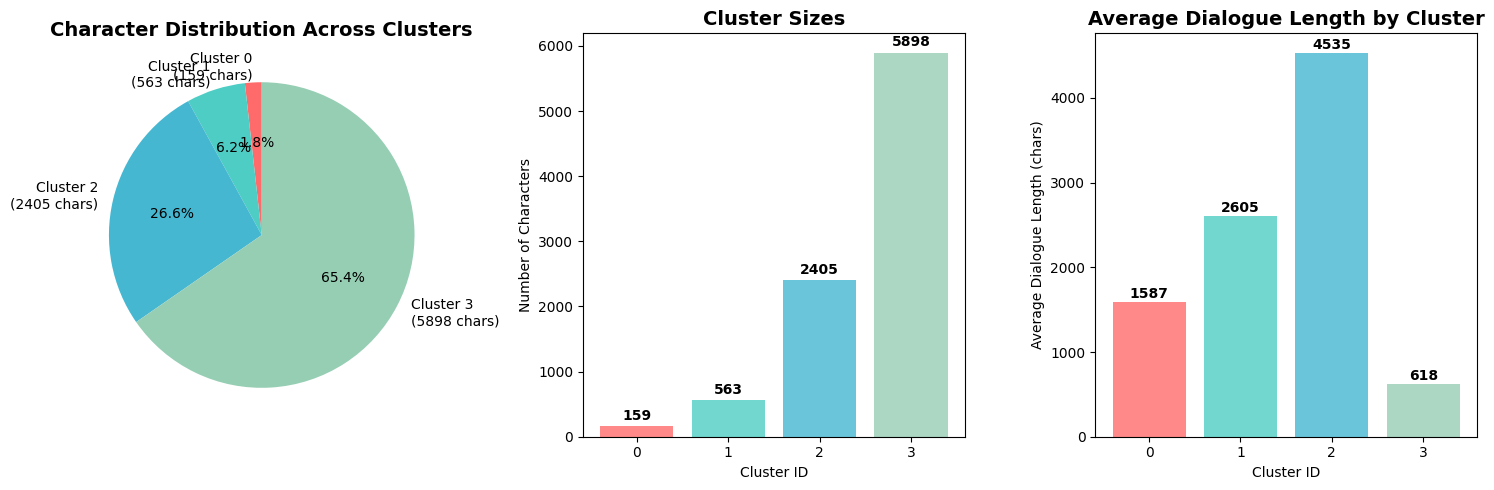

🔄 Creating 2D visualization using PCA...
🔄 Creating t-SNE visualization (using sample for speed)...


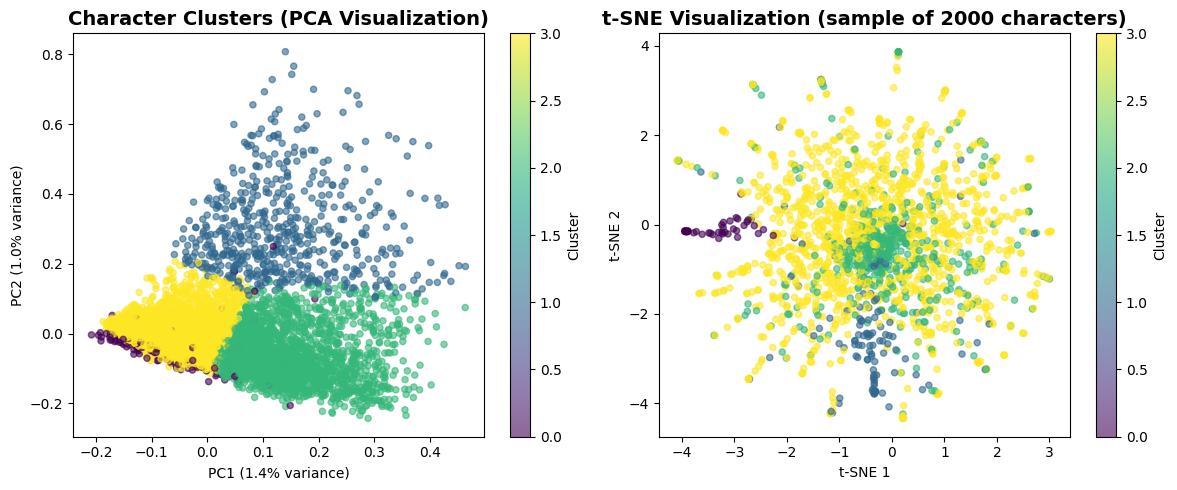

🔄 Creating top words heatmap...


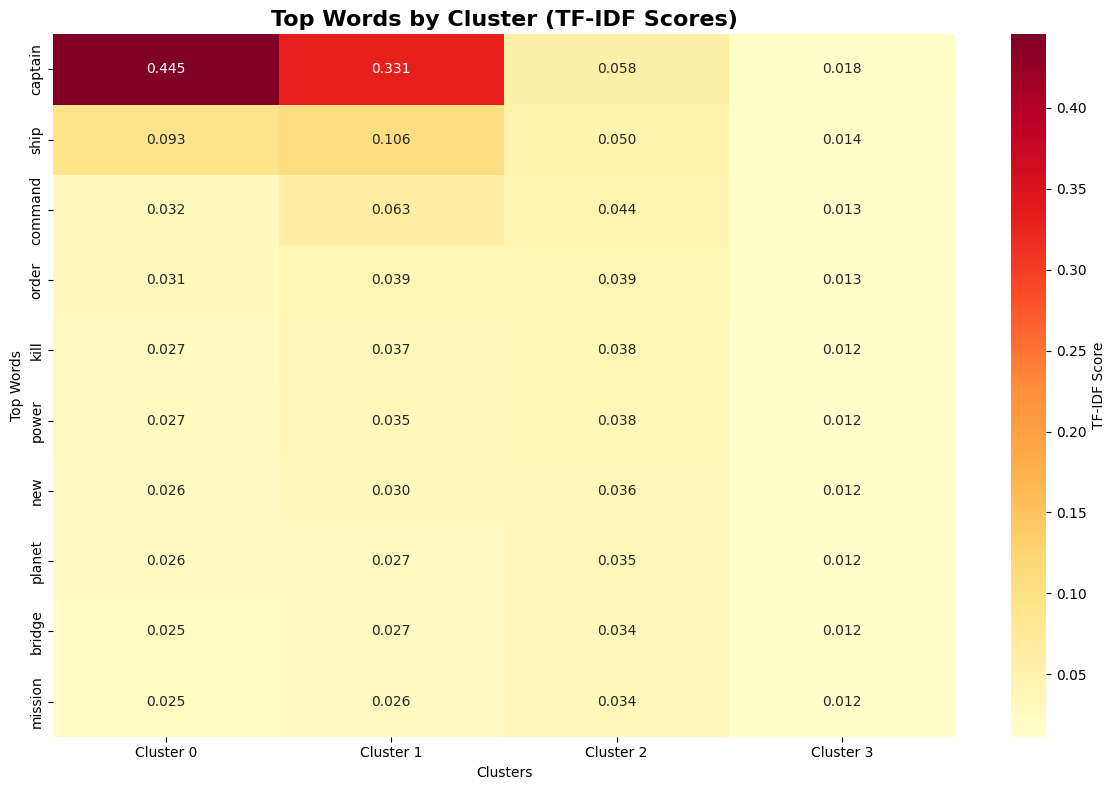

✅ All visualizations complete!


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# 1. CLUSTER DISTRIBUTION PIE CHART
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
cluster_counts = df_clean['semantic_cluster'].value_counts().sort_index()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
labels = [f'Cluster {i}\n({count} chars)' for i, count in enumerate(cluster_counts)]

plt.pie(cluster_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Character Distribution Across Clusters', fontsize=14, fontweight='bold')

# 2. CLUSTER SIZE BAR CHART
plt.subplot(1, 3, 2)
bars = plt.bar(range(4), cluster_counts, color=colors, alpha=0.8)
plt.xlabel('Cluster ID')
plt.ylabel('Number of Characters')
plt.title('Cluster Sizes', fontsize=14, fontweight='bold')
plt.xticks(range(4))

# Add value labels on bars
for bar, count in zip(bars, cluster_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             str(count), ha='center', va='bottom', fontweight='bold')

# 3. AVERAGE DIALOGUE LENGTH BY CLUSTER
plt.subplot(1, 3, 3)
avg_lengths = df_clean.groupby('semantic_cluster')['processed_dialogues'].apply(lambda x: x.str.len().mean())
bars = plt.bar(range(4), avg_lengths, color=colors, alpha=0.8)
plt.xlabel('Cluster ID')
plt.ylabel('Average Dialogue Length (chars)')
plt.title('Average Dialogue Length by Cluster', fontsize=14, fontweight='bold')
plt.xticks(range(4))

# Add value labels
for bar, length in zip(bars, avg_lengths):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
             f'{int(length)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 4. 2D VISUALIZATION USING PCA
print("🔄 Creating 2D visualization using PCA...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_semantic.toarray())

plt.figure(figsize=(12, 5))

# PCA Plot
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=df_clean['semantic_cluster'], 
                     cmap='viridis', alpha=0.6, s=20)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Character Clusters (PCA Visualization)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')

# 5. 2D VISUALIZATION USING t-SNE (sample for speed)
print("🔄 Creating t-SNE visualization (using sample for speed)...")
sample_size = min(2000, len(df_clean))  # Sample for t-SNE speed
sample_indices = np.random.choice(len(df_clean), sample_size, replace=False)
X_sample = X_semantic[sample_indices].toarray()
clusters_sample = df_clean.iloc[sample_indices]['semantic_cluster']

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_sample)

plt.subplot(1, 2, 2)
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                     c=clusters_sample, 
                     cmap='viridis', alpha=0.6, s=20)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title(f't-SNE Visualization (sample of {sample_size} characters)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')

plt.tight_layout()
plt.show()

# 6. TOP WORDS HEATMAP
print("🔄 Creating top words heatmap...")
# Get top 10 words for each cluster
n_top_words = 10
top_words_matrix = []
word_labels = []

for i in range(4):
    top_indices = cluster_centers[i].argsort()[-n_top_words:][::-1]
    top_words = [feature_names[idx] for idx in top_indices]
    top_scores = [cluster_centers[i][idx] for idx in top_indices]
    
    if i == 0:  # First cluster, get word labels
        word_labels = top_words
    
    top_words_matrix.append(top_scores)

# Create heatmap
plt.figure(figsize=(12, 8))
heatmap_data = np.array(top_words_matrix).T  # Transpose for better visualization

sns.heatmap(heatmap_data, 
            xticklabels=[f'Cluster {i}' for i in range(4)],
            yticklabels=word_labels,
            annot=True, 
            fmt='.3f',
            cmap='YlOrRd',
            cbar_kws={'label': 'TF-IDF Score'})

plt.title('Top Words by Cluster (TF-IDF Scores)', fontsize=16, fontweight='bold')
plt.xlabel('Clusters')
plt.ylabel('Top Words')
plt.tight_layout()
plt.show()

print("✅ All visualizations complete!")

In [9]:
%pip install textblob


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 KB 6.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


Sentiment analysis on Surface level

📖 Loading data for sentiment analysis...
Clustered data: 9025 characters
Surface data: 9025 characters

🔍 Loading TF-IDF model to analyze cluster content...

🔄 Extracting sentiment features...
Processing sentiment...
  Processed 0/9025...
  Processed 1000/9025...
  Processed 2000/9025...
  Processed 3000/9025...
  Processed 4000/9025...
  Processed 5000/9025...
  Processed 6000/9025...
  Processed 7000/9025...
  Processed 8000/9025...
  Processed 9000/9025...

🔗 Combining clusters with sentiment features...
✅ Added sentiment features to 9025 characters

📊 DATA-DRIVEN Sentiment Analysis by Persona Cluster:

🎭 CLUSTER 0 - 159 characters
--------------------------------------------------
🔑 Top defining words: captain, ship, command, order, kill, power, new, planet
📊 Sentiment Profile:
   Polarity: 0.066 (Neutral)
   Subjectivity: 0.488 (Objective)
   Emotional Intensity: 0.044 (Low)
🎭 Data-Driven Persona: Authority/Commander

💬 Sample Dialogues:
   • AGENT (P:-0.00, S:0.46)
     "do n't k

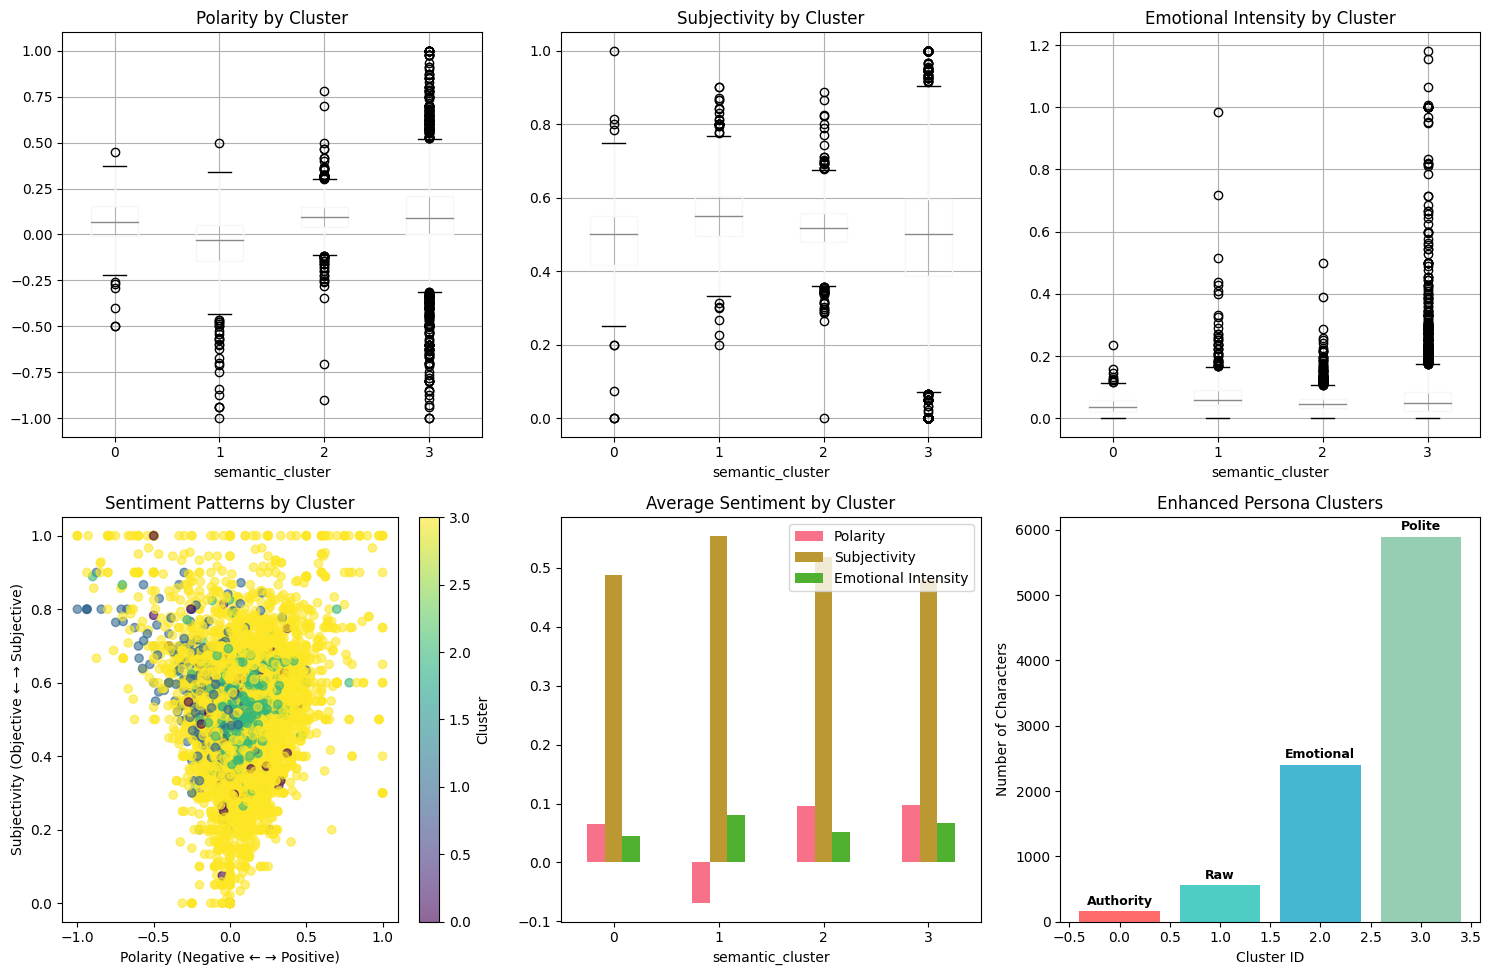


💾 Saved enhanced persona data to 'persona_clusters_with_sentiment.csv'

🎭 FINAL DATA-DRIVEN ENHANCED PERSONAS:

🎭 Persona 0: Authority/Commander
   Characters: 159
   Sentiment: 0.066 polarity, 0.488 subjectivity, 0.044 intensity
   Traits: Neutral tone, Objective style

🎭 Persona 1: Raw/Aggressive Speaker
   Characters: 563
   Sentiment: -0.069 polarity, 0.554 subjectivity, 0.080 intensity
   Traits: Neutral tone, Subjective style

🎭 Persona 2: Emotional/Caring Speaker
   Characters: 2405
   Sentiment: 0.095 polarity, 0.518 subjectivity, 0.051 intensity
   Traits: Neutral tone, Subjective style

🎭 Persona 3: Polite/Friendly Speaker
   Characters: 5898
   Sentiment: 0.097 polarity, 0.479 subjectivity, 0.067 intensity
   Traits: Neutral tone, Objective style

✅ Sentiment analysis complete! Your personas are now data-driven with emotional profiles.


In [11]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load the clustered data and surface-level processed data
print("📖 Loading data for sentiment analysis...")
clustered_df = pd.read_csv('improved_semantic_clusters.csv')
surface_df = pd.read_csv('processed_dialogues_surface.csv')

# Match the data (ensure same characters)
surface_df_clean = surface_df.dropna(subset=['processed_dialogues'])
surface_df_clean = surface_df_clean[surface_df_clean['processed_dialogues'] != '']

print(f"Clustered data: {len(clustered_df)} characters")
print(f"Surface data: {len(surface_df_clean)} characters")

# Load TF-IDF model to get actual top words for each cluster
print("\n🔍 Loading TF-IDF model to analyze cluster content...")
vectorizer = joblib.load('improved_tfidf_vectorizer.pkl')
kmeans_model = joblib.load('improved_kmeans_model.pkl')
feature_names = vectorizer.get_feature_names_out()
cluster_centers = kmeans_model.cluster_centers_

# Extract sentiment features from surface-level dialogues
print("\n🔄 Extracting sentiment features...")

def extract_sentiment_features(text):
    """Extract sentiment features from surface-level text"""
    if pd.isna(text) or text == '':
        return [0, 0, 0]
    
    blob = TextBlob(str(text))
    
    # Basic sentiment
    polarity = blob.sentiment.polarity  # -1 (negative) to 1 (positive)
    subjectivity = blob.sentiment.subjectivity  # 0 (objective) to 1 (subjective)
    
    # Emotional intensity markers from surface text
    exclamation_count = text.count('!')
    question_count = text.count('?')
    caps_words = len([word for word in text.split() if word.isupper() and len(word) > 1])
    
    # Emotional intensity score (normalized by text length)
    word_count = len(text.split())
    emotional_intensity = (exclamation_count + question_count + caps_words) / word_count if word_count > 0 else 0
    
    return [polarity, subjectivity, emotional_intensity]

# Process sentiment for all characters
sentiment_data = []
print("Processing sentiment...")

for idx, text in enumerate(surface_df_clean['processed_dialogues']):
    if idx % 1000 == 0:
        print(f"  Processed {idx}/{len(surface_df_clean)}...")
    
    features = extract_sentiment_features(text)
    sentiment_data.append(features)

sentiment_array = np.array(sentiment_data)

# Create combined dataframe with clusters and sentiment
print("\n🔗 Combining clusters with sentiment features...")

# Add sentiment to clustered data
clustered_df['polarity'] = sentiment_array[:len(clustered_df), 0]
clustered_df['subjectivity'] = sentiment_array[:len(clustered_df), 1] 
clustered_df['emotional_intensity'] = sentiment_array[:len(clustered_df), 2]

print(f"✅ Added sentiment features to {len(clustered_df)} characters")

# Function to determine persona based on actual cluster content
def determine_persona_from_data(cluster_id, top_words, avg_polarity, avg_subjectivity, avg_intensity):
    """Determine persona name based on actual data, not hardcoded assumptions"""
    top_words_str = ' '.join(top_words)
    
    if any(word in top_words for word in ['fuck', 'shit', 'fuckin', 'hell']) and avg_intensity > 0.07:
        return "Raw/Aggressive Speaker"
    elif any(word in top_words for word in ['captain', 'command', 'order', 'ship', 'mission']):
        return "Authority/Commander"
    elif any(word in top_words for word in ['love', 'feel', 'god', 'life', 'help', 'sorry']) and avg_subjectivity > 0.5:
        return "Emotional/Caring Speaker"
    elif avg_polarity > 0.05 and avg_intensity < 0.07:
        return "Polite/Friendly Speaker"
    else:
        return "General Conversationalist"

# Analyze sentiment by cluster with data-driven persona names
print("\n📊 DATA-DRIVEN Sentiment Analysis by Persona Cluster:")
print("="*70)

cluster_personas = {}  # Store actual persona names

for cluster_id in range(4):
    cluster_data = clustered_df[clustered_df['semantic_cluster'] == cluster_id]
    
    print(f"\n🎭 CLUSTER {cluster_id} - {len(cluster_data)} characters")
    print("-" * 50)
    
    # Get TOP DEFINING WORDS for this cluster
    top_indices = cluster_centers[cluster_id].argsort()[-10:][::-1]
    top_words = [feature_names[idx] for idx in top_indices]
    print(f"🔑 Top defining words: {', '.join(top_words[:8])}")
    
    # Calculate average sentiment metrics
    avg_polarity = cluster_data['polarity'].mean()
    avg_subjectivity = cluster_data['subjectivity'].mean() 
    avg_intensity = cluster_data['emotional_intensity'].mean()
    
    print(f"📊 Sentiment Profile:")
    print(f"   Polarity: {avg_polarity:.3f} ({'Positive' if avg_polarity > 0.1 else 'Negative' if avg_polarity < -0.1 else 'Neutral'})")
    print(f"   Subjectivity: {avg_subjectivity:.3f} ({'Subjective' if avg_subjectivity > 0.5 else 'Objective'})")
    print(f"   Emotional Intensity: {avg_intensity:.3f} ({'High' if avg_intensity > 0.05 else 'Low'})")
    
    # Determine persona based on ACTUAL DATA
    persona_name = determine_persona_from_data(cluster_id, top_words, avg_polarity, avg_subjectivity, avg_intensity)
    cluster_personas[cluster_id] = persona_name
    
    print(f"🎭 Data-Driven Persona: {persona_name}")
    
    # Show sample dialogues with sentiment context
    print(f"\n💬 Sample Dialogues:")
    samples = cluster_data.sample(min(2, len(cluster_data)), random_state=42)
    for _, row in samples.iterrows():
        print(f"   • {row['character_name']} (P:{row['polarity']:.2f}, S:{row['subjectivity']:.2f})")
        print(f"     \"{row['processed_dialogues'][:150]}...\"")

# Visualize sentiment patterns by cluster
print("\n📈 Creating sentiment visualizations...")

plt.figure(figsize=(15, 10))

# 1. Sentiment by cluster - box plots
plt.subplot(2, 3, 1)
clustered_df.boxplot(column='polarity', by='semantic_cluster', ax=plt.gca())
plt.title('Polarity by Cluster')
plt.suptitle('')  # Remove automatic title

plt.subplot(2, 3, 2)
clustered_df.boxplot(column='subjectivity', by='semantic_cluster', ax=plt.gca())
plt.title('Subjectivity by Cluster')
plt.suptitle('')

plt.subplot(2, 3, 3)
clustered_df.boxplot(column='emotional_intensity', by='semantic_cluster', ax=plt.gca())
plt.title('Emotional Intensity by Cluster')
plt.suptitle('')

# 4. Scatter plot: Polarity vs Subjectivity colored by cluster
plt.subplot(2, 3, 4)
scatter = plt.scatter(clustered_df['polarity'], clustered_df['subjectivity'], 
                     c=clustered_df['semantic_cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Polarity (Negative ← → Positive)')
plt.ylabel('Subjectivity (Objective ← → Subjective)')
plt.title('Sentiment Patterns by Cluster')
plt.colorbar(scatter, label='Cluster')

# 5. Average sentiment by cluster - bar chart
plt.subplot(2, 3, 5)
avg_sentiment = clustered_df.groupby('semantic_cluster')[['polarity', 'subjectivity', 'emotional_intensity']].mean()
avg_sentiment.plot(kind='bar', ax=plt.gca())
plt.title('Average Sentiment by Cluster')
plt.xticks(rotation=0)
plt.legend(['Polarity', 'Subjectivity', 'Emotional Intensity'])

# 6. Cluster distribution with DATA-DRIVEN labels
plt.subplot(2, 3, 6)
cluster_counts = clustered_df['semantic_cluster'].value_counts().sort_index()
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = plt.bar(range(4), cluster_counts, color=colors)
plt.xlabel('Cluster ID')
plt.ylabel('Number of Characters')
plt.title('Enhanced Persona Clusters')

# Add DATA-DRIVEN persona labels (shortened for display)
persona_labels = [cluster_personas[i].split('/')[0] for i in range(4)]
for i, (bar, label) in enumerate(zip(bars, persona_labels)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             label, ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# Save enhanced results
clustered_df.to_csv('persona_clusters_with_sentiment.csv', index=False)
print(f"\n💾 Saved enhanced persona data to 'persona_clusters_with_sentiment.csv'")

# Summary of enhanced personas with DATA-DRIVEN names
print("\n🎭 FINAL DATA-DRIVEN ENHANCED PERSONAS:")
print("="*70)
for i in range(4):
    cluster_data = clustered_df[clustered_df['semantic_cluster'] == i]
    avg_pol = cluster_data['polarity'].mean()
    avg_sub = cluster_data['subjectivity'].mean()
    avg_int = cluster_data['emotional_intensity'].mean()
    
    print(f"\n🎭 Persona {i}: {cluster_personas[i]}")
    print(f"   Characters: {len(cluster_data)}")
    print(f"   Sentiment: {avg_pol:.3f} polarity, {avg_sub:.3f} subjectivity, {avg_int:.3f} intensity")
    print(f"   Traits: {('Positive' if avg_pol > 0.1 else 'Negative' if avg_pol < -0.1 else 'Neutral')} tone, {('Subjective' if avg_sub > 0.5 else 'Objective')} style")

print("\n✅ Sentiment analysis complete! Your personas are now data-driven with emotional profiles.")

In [12]:
import joblib
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load existing data
clustered_df = pd.read_csv('persona_clusters_with_sentiment.csv')

# Recreate the feature matrices
print("🔄 Recreating and saving all vectorization components...")

# 1. Load original TF-IDF vectors
vectorizer = joblib.load('improved_tfidf_vectorizer.pkl')
X_tfidf = vectorizer.transform(clustered_df['processed_dialogues'])

# 2. Extract sentiment features
sentiment_features = clustered_df[['polarity', 'subjectivity', 'emotional_intensity']].values

# 3. Normalize sentiment features
scaler = StandardScaler()
sentiment_scaled = scaler.fit_transform(sentiment_features)

# 4. Combine TF-IDF + Sentiment
combined_features = np.hstack([
    X_tfidf.toarray(),  # TF-IDF features
    sentiment_scaled    # Sentiment features
])

print(f"✅ Combined feature matrix shape: {combined_features.shape}")

# 5. Save everything
joblib.dump(vectorizer, 'final_tfidf_vectorizer.pkl')
joblib.dump(scaler, 'sentiment_scaler.pkl') 
joblib.dump(combined_features, 'combined_tfidf_sentiment_features.pkl')

# 6. Also save the final clustering model
final_kmeans = KMeans(n_clusters=4, random_state=42)
final_kmeans.fit(combined_features)
joblib.dump(final_kmeans, 'final_persona_clustering_model.pkl')

print("💾 Saved all vectorization components:")
print("  - final_tfidf_vectorizer.pkl")
print("  - sentiment_scaler.pkl") 
print("  - combined_tfidf_sentiment_features.pkl")
print("  - final_persona_clustering_model.pkl")

# Test loading
print("\n🧪 Testing saved components...")
loaded_vectorizer = joblib.load('final_tfidf_vectorizer.pkl')
loaded_scaler = joblib.load('sentiment_scaler.pkl')
loaded_features = joblib.load('combined_tfidf_sentiment_features.pkl')
loaded_model = joblib.load('final_persona_clustering_model.pkl')

print(f"✅ All components loaded successfully!")
print(f"Feature matrix: {loaded_features.shape}")
print(f"Vectorizer vocabulary size: {len(loaded_vectorizer.get_feature_names_out())}")

🔄 Recreating and saving all vectorization components...


/home/samanvitha/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['wan'] not in stop_words.
  warnings.warn(


✅ Combined feature matrix shape: (9025, 803)
💾 Saved all vectorization components:
  - final_tfidf_vectorizer.pkl
  - sentiment_scaler.pkl
  - combined_tfidf_sentiment_features.pkl
  - final_persona_clustering_model.pkl

🧪 Testing saved components...
✅ All components loaded successfully!
Feature matrix: (9025, 803)
Vectorizer vocabulary size: 800


Topic Modeling

In [24]:
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

print("🔥 FINAL ATTEMPT - Proper topic modeling...")

# Load data
full_df = pd.read_csv('processed_dialogues_full.csv')
full_clean = full_df.dropna(subset=['processed_dialogues']).copy()
full_clean = full_clean[full_clean['processed_dialogues'].str.strip() != '']

# Create DOMAIN-SPECIFIC vocabulary (remove duplicates)
domain_words = list(set([  # Use set() to remove duplicates
    # Family/Relationships
    'family', 'mother', 'father', 'brother', 'sister', 'daughter', 'husband', 'wife', 
    'children', 'parents', 'marriage', 'wedding', 'divorce', 'relationship',
    
    # Military/Authority  
    'captain', 'commander', 'officer', 'soldier', 'military', 'army', 'navy', 'war',
    'battle', 'enemy', 'weapon', 'command', 'orders', 'mission', 'attack',
    
    # Crime/Legal
    'police', 'detective', 'criminal', 'arrest', 'prison', 'court', 'judge', 'lawyer',
    'crime', 'murder', 'robbery', 'investigation', 'evidence', 'guilty', 'innocent',
    
    # Medical/Health
    'doctor', 'hospital', 'patient', 'medicine', 'treatment', 'surgery', 'nurse',
    'disease', 'illness', 'health', 'medical', 'emergency', 'ambulance',
    
    # Business/Money
    'business', 'company', 'money', 'dollars', 'payment', 'contract', 'deal',
    'investment', 'profit', 'finance', 'bank', 'economy', 'market', 'client',
    
    # Location/Travel
    'house', 'building', 'street', 'city', 'country', 'airport', 'hotel', 'restaurant',
    'office', 'school', 'church', 'station', 'bridge',
    
    # Technology/Science
    'computer', 'technology', 'science', 'research', 'experiment', 'laboratory',
    'machine', 'device', 'system', 'program', 'data', 'information',
    
    # Entertainment/Arts
    'music', 'movie', 'television', 'performance', 'artist', 'actor', 'director',
    'theatre', 'concert', 'dance', 'painting', 'book', 'story'
]))

print(f"Domain vocabulary size: {len(domain_words)}")
print(f"Sample words: {sorted(domain_words)[:10]}")

# Use only domain-specific vocabulary
domain_vectorizer = CountVectorizer(
    vocabulary=domain_words,              # ONLY use our curated vocabulary
    binary=True,                         # Binary occurrence (not frequency)
    lowercase=True
)

print("🔄 Creating domain-specific matrix...")
X_domain = domain_vectorizer.fit_transform(full_clean['processed_dialogues'])
print(f"Domain matrix shape: {X_domain.shape}")

# Check which words actually appear
feature_names = domain_vectorizer.get_feature_names_out()
word_counts = X_domain.sum(axis=0).A1
word_freq = [(word, count) for word, count in zip(feature_names, word_counts) if count > 0]
word_freq.sort(key=lambda x: x[1], reverse=True)

print(f"\nTop domain words found:")
for word, count in word_freq[:20]:
    print(f"  {word}: {count} documents")

# Only proceed if we have enough meaningful words
if len(word_freq) < 10:
    print("❌ Not enough domain-specific words found! Topic modeling not meaningful.")
else:
    # Topic modeling on domain words only
    domain_lda = LatentDirichletAllocation(
        n_components=min(6, len(word_freq)//3),  # Adjust topics based on available words
        random_state=42,
        max_iter=100,
        doc_topic_prior=0.1,
        topic_word_prior=0.1
    )
    
    print("🎭 Discovering semantic topics...")
    topic_probs = domain_lda.fit_transform(X_domain)
    
    print("\n🎯 SEMANTIC TOPICS (domain-specific words only):")
    print("="*60)
    
    topic_names = []
    for topic_idx, topic in enumerate(domain_lda.components_):
        # Get top words for this topic
        top_indices = topic.argsort()[-8:][::-1]
        top_words = [feature_names[i] for i in top_indices if topic[i] > 0.01]
        
        if len(top_words) == 0:
            continue
            
        print(f"\nTopic {topic_idx}: {', '.join(top_words)}")
        
        # Determine theme based on word clusters
        words_set = set(top_words)
        
        family_words = {'family', 'mother', 'father', 'brother', 'sister', 'daughter', 'husband', 'wife', 'children', 'parents', 'marriage', 'wedding'}
        military_words = {'captain', 'commander', 'officer', 'soldier', 'military', 'army', 'navy', 'war', 'battle', 'enemy', 'weapon', 'command', 'orders', 'mission'}
        crime_words = {'police', 'detective', 'criminal', 'arrest', 'prison', 'court', 'judge', 'lawyer', 'crime', 'murder', 'investigation'}
        medical_words = {'doctor', 'hospital', 'patient', 'medicine', 'treatment', 'surgery', 'nurse', 'medical', 'emergency'}
        business_words = {'business', 'company', 'money', 'dollars', 'payment', 'contract', 'deal', 'investment', 'profit', 'finance', 'bank'}
        location_words = {'house', 'building', 'street', 'city', 'country', 'airport', 'hotel', 'restaurant', 'office', 'school', 'church'}
        
        if len(words_set & family_words) >= 1:
            theme = "Family/Personal"
        elif len(words_set & military_words) >= 1:
            theme = "Military/Authority"
        elif len(words_set & crime_words) >= 1:
            theme = "Crime/Legal"
        elif len(words_set & medical_words) >= 1:
            theme = "Medical/Health"
        elif len(words_set & business_words) >= 1:
            theme = "Business/Finance"
        elif len(words_set & location_words) >= 1:
            theme = "Location/Places"
        else:
            theme = f"Mixed-{topic_idx}"
        
        topic_names.append(theme)
        print(f"Theme: {theme}")
    
    # Show topic distributions
    print(f"\n📊 Topic prevalence:")
    topic_means = topic_probs.mean(axis=0)
    for i, (theme, mean_prob) in enumerate(zip(topic_names, topic_means)):
        print(f"{theme}: {mean_prob:.3f}")
    
    # Save results
    for i, theme in enumerate(topic_names):
        full_clean[f'topic_{theme.replace("/", "_").replace(" ", "_")}'] = topic_probs[:, i]
    
    full_clean.to_csv('semantic_topics_final.csv', index=False)
    print(f"\n💾 Saved semantic topic results!")

print("\n✅ Domain-specific topic modeling complete!")

🔥 FINAL ATTEMPT - Proper topic modeling...
Domain vocabulary size: 109
Sample words: ['actor', 'airport', 'ambulance', 'army', 'arrest', 'artist', 'attack', 'bank', 'battle', 'book']
🔄 Creating domain-specific matrix...
Domain matrix shape: (9022, 109)

Top domain words found:
  money: 1280 documents
  house: 1053 documents
  father: 944 documents
  mother: 918 documents
  business: 886 documents
  deal: 855 documents
  wife: 767 documents
  school: 719 documents
  family: 708 documents
  story: 705 documents
  doctor: 604 documents
  book: 593 documents
  brother: 577 documents
  police: 538 documents
  street: 529 documents
  office: 495 documents
  city: 485 documents
  country: 481 documents
  war: 432 documents
  husband: 395 documents
🎭 Discovering semantic topics...

🎯 SEMANTIC TOPICS (domain-specific words only):

Topic 0: father, mother, family, brother, doctor, sister, school, house
Theme: Family/Personal

Topic 1: war, captain, attack, system, army, country, weapon, mission


In [28]:
import joblib
import numpy as np
from sklearn.preprocessing import StandardScaler

print("💾 Saving ALL missing vectors...")

# Load the sentiment analysis data
clustered_df = pd.read_csv('persona_clusters_with_sentiment.csv')

# 1. RECREATE SENTIMENT ANALYSIS VECTORS
print("🔄 Recreating sentiment analysis vectors...")

# Load original TF-IDF
tfidf_vectorizer = joblib.load('improved_tfidf_vectorizer.pkl')
X_tfidf = tfidf_vectorizer.transform(clustered_df['processed_dialogues'])

# Extract sentiment features
sentiment_features = clustered_df[['polarity', 'subjectivity', 'emotional_intensity']].values

# Scale sentiment features
sentiment_scaler = StandardScaler()
sentiment_scaled = sentiment_scaler.fit_transform(sentiment_features)

# Combine TF-IDF + Sentiment
combined_features = np.hstack([X_tfidf.toarray(), sentiment_scaled])

# 2. SAVE SENTIMENT ANALYSIS VECTORS
joblib.dump(combined_features, 'sentiment_combined_feature_matrix.pkl')
joblib.dump(sentiment_scaler, 'sentiment_feature_scaler.pkl')
joblib.dump(X_tfidf, 'sentiment_tfidf_matrix.pkl')

print("✅ Saved sentiment analysis vectors:")
print("  - sentiment_combined_feature_matrix.pkl")
print("  - sentiment_feature_scaler.pkl") 
print("  - sentiment_tfidf_matrix.pkl")

# 3. SAVE TOPIC MODELING VECTORS (from previous)
joblib.dump(domain_vectorizer, 'topic_domain_vectorizer.pkl')
joblib.dump(X_domain, 'topic_term_document_matrix.pkl')
joblib.dump(domain_lda, 'topic_lda_model.pkl')
joblib.dump(topic_names, 'topic_theme_names.pkl')

print("✅ Saved topic modeling vectors:")
print("  - topic_domain_vectorizer.pkl")
print("  - topic_term_document_matrix.pkl")
print("  - topic_lda_model.pkl") 
print("  - topic_theme_names.pkl")

print("\n🎯 NOW YOU HAVE ALL VECTORS SAVED!")
print("Ready for new character classification and model deployment!")

💾 Saving ALL missing vectors...
🔄 Recreating sentiment analysis vectors...


/home/samanvitha/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['wan'] not in stop_words.
  warnings.warn(


✅ Saved sentiment analysis vectors:
  - sentiment_combined_feature_matrix.pkl
  - sentiment_feature_scaler.pkl
  - sentiment_tfidf_matrix.pkl
✅ Saved topic modeling vectors:
  - topic_domain_vectorizer.pkl
  - topic_term_document_matrix.pkl
  - topic_lda_model.pkl
  - topic_theme_names.pkl

🎯 NOW YOU HAVE ALL VECTORS SAVED!
Ready for new character classification and model deployment!


Metadata stylistic patterns

🎨 Extracting stylistic metadata features...
Loaded 9025 characters
🔄 Processing stylistic features for all characters...
  Processed 0/9025...
  Processed 1000/9025...
  Processed 2000/9025...
  Processed 3000/9025...
  Processed 4000/9025...
  Processed 5000/9025...
  Processed 6000/9025...
  Processed 7000/9025...
  Processed 8000/9025...
  Processed 9000/9025...
✅ Added 20 stylistic features!

🎭 STYLISTIC PATTERNS BY PERSONA:

🎭 CLUSTER 0 (159 characters)
--------------------------------------------------
🎨 Top Stylistic Patterns:
   Avg Sentence Length: 12.1806
   Sentence Variety: 8.5065
   Avg Word Length: 3.6476
   Text Density: 3.6476
   Short Words Ratio: 0.5474

📊 Style Profile:
   Emotional: Low exclamations (0.010)
   Inquisitive: High questions (0.024)
   Emphasis: Low capitals (0.000)
   Language: Clean (0.004 profanity)
   Register: Casual (0.0002)
   Verbosity: Verbose (12.2 avg words/sentence)

🎭 CLUSTER 1 (563 characters)
----------------------------------------------

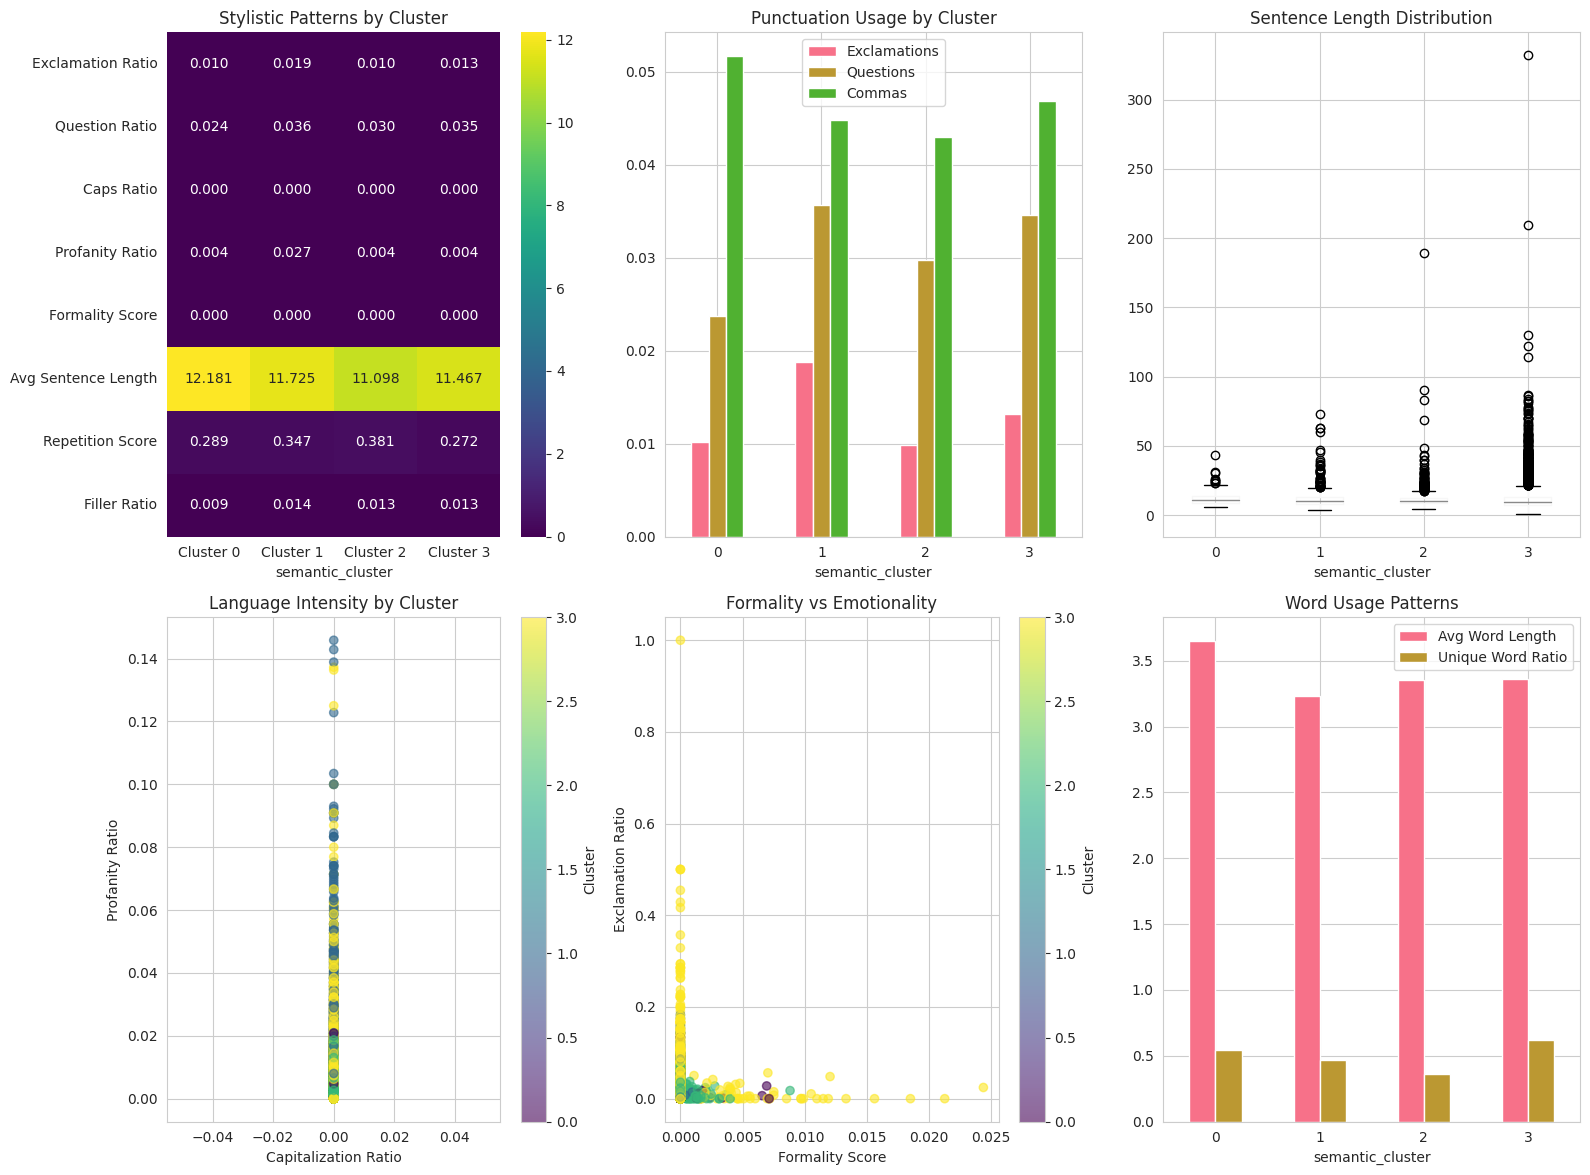


💾 Saved enhanced dataset with stylistic features!

🎭 ENHANCED STYLISTIC PERSONAS:

🎭 Cluster 0: Authority/Commander
   Style: Calm, Inquisitive, Subdued, Clean, Casual
   Characters: 159

🎭 Cluster 1: Raw/Aggressive Speaker
   Style: Calm, Inquisitive, Subdued, Rough, Casual
   Characters: 563

🎭 Cluster 2: Emotional/Caring Speaker
   Style: Calm, Inquisitive, Subdued, Clean, Casual
   Characters: 2405

🎭 Cluster 3: Polite/Friendly Speaker
   Style: Calm, Inquisitive, Subdued, Clean, Casual
   Characters: 5898

✅ Stylistic metadata analysis complete!


In [31]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

print("🎨 Extracting stylistic metadata features...")

# Load data (use the semantic level for style analysis)
df = pd.read_csv('persona_clusters_with_sentiment.csv')
print(f"Loaded {len(df)} characters")

def extract_stylistic_features(text):
    """Extract comprehensive stylistic patterns from dialogue"""
    if pd.isna(text) or text == '':
        return {}
    
    text = str(text)
    words = text.split()
    sentences = [s.strip() for s in text.split('.') if s.strip()]
    
    features = {}
    
    # 1. PUNCTUATION PATTERNS
    features['exclamation_ratio'] = text.count('!') / len(words) if words else 0
    features['question_ratio'] = text.count('?') / len(words) if words else 0
    features['ellipsis_count'] = text.count('...') + text.count('..') 
    features['dash_count'] = text.count('--') + text.count(' - ')
    features['comma_ratio'] = text.count(',') / len(words) if words else 0
    
    # 2. CAPITALIZATION PATTERNS
    caps_words = [w for w in words if w.isupper() and len(w) > 1]
    features['caps_ratio'] = len(caps_words) / len(words) if words else 0
    features['caps_intensity'] = sum(len(w) for w in caps_words) / len(text) if text else 0
    
    # 3. SENTENCE STRUCTURE
    if sentences:
        features['avg_sentence_length'] = np.mean([len(s.split()) for s in sentences])
        features['sentence_variety'] = np.std([len(s.split()) for s in sentences])
        features['short_sentences_ratio'] = sum(1 for s in sentences if len(s.split()) <= 3) / len(sentences)
    else:
        features['avg_sentence_length'] = 0
        features['sentence_variety'] = 0
        features['short_sentences_ratio'] = 0
    
    # 4. WORD PATTERNS
    if words:
        word_lengths = [len(w) for w in words]
        features['avg_word_length'] = np.mean(word_lengths)
        features['long_words_ratio'] = sum(1 for w in words if len(w) > 6) / len(words)
        features['short_words_ratio'] = sum(1 for w in words if len(w) <= 3) / len(words)
    else:
        features['avg_word_length'] = 0
        features['long_words_ratio'] = 0
        features['short_words_ratio'] = 0
    
    # 5. REPETITION PATTERNS
    word_counts = Counter(words)
    features['repetition_score'] = sum(1 for count in word_counts.values() if count > 1) / len(word_counts) if word_counts else 0
    features['unique_word_ratio'] = len(word_counts) / len(words) if words else 0
    
    # 6. PROFANITY/INTENSITY MARKERS
    profanity_words = ['fuck', 'shit', 'damn', 'hell', 'ass', 'bitch', 'bastard']
    features['profanity_ratio'] = sum(text.lower().count(word) for word in profanity_words) / len(words) if words else 0
    
    # 7. HESITATION/FILLER PATTERNS
    fillers = ['um', 'uh', 'well', 'like', 'you know', 'i mean', 'sort of', 'kind of']
    features['filler_ratio'] = sum(text.lower().count(filler) for filler in fillers) / len(words) if words else 0
    
    # 8. FORMALITY INDICATORS
    formal_words = ['therefore', 'however', 'furthermore', 'moreover', 'nevertheless', 'consequently']
    features['formality_score'] = sum(text.lower().count(word) for word in formal_words) / len(words) if words else 0
    
    # 9. EMOTIONAL INTENSITY
    features['text_density'] = len(text.replace(' ', '')) / len(words) if words else 0
    features['punctuation_density'] = (text.count('!') + text.count('?') + text.count('.')) / len(words) if words else 0
    
    return features

print("🔄 Processing stylistic features for all characters...")

# Extract features for all characters
stylistic_data = []
feature_names = []

for idx, text in enumerate(df['processed_dialogues']):
    if idx % 1000 == 0:
        print(f"  Processed {idx}/{len(df)}...")
    
    features = extract_stylistic_features(text)
    if idx == 0:
        feature_names = list(features.keys())
    stylistic_data.append(list(features.values()))

# Convert to DataFrame
stylistic_df = pd.DataFrame(stylistic_data, columns=feature_names)

# Add to main dataframe
for col in feature_names:
    df[f'style_{col}'] = stylistic_df[col]

print(f"✅ Added {len(feature_names)} stylistic features!")

# Analyze stylistic patterns by persona cluster
print("\n🎭 STYLISTIC PATTERNS BY PERSONA:")
print("="*60)

style_cols = [col for col in df.columns if col.startswith('style_')]

for cluster_id in range(4):
    cluster_data = df[df['semantic_cluster'] == cluster_id]
    
    print(f"\n🎭 CLUSTER {cluster_id} ({len(cluster_data)} characters)")
    print("-" * 50)
    
    # Calculate average stylistic features
    style_means = cluster_data[style_cols].mean()
    
    # Get top distinctive features
    top_features = style_means.nlargest(5)
    
    print("🎨 Top Stylistic Patterns:")
    for feature, value in top_features.items():
        clean_name = feature.replace('style_', '').replace('_', ' ').title()
        print(f"   {clean_name}: {value:.4f}")
    
    # Create persona style profile
    exclamation = style_means['style_exclamation_ratio']
    question = style_means['style_question_ratio'] 
    caps = style_means['style_caps_ratio']
    profanity = style_means['style_profanity_ratio']
    formality = style_means['style_formality_score']
    sentence_len = style_means['style_avg_sentence_length']
    
    print(f"\n📊 Style Profile:")
    print(f"   Emotional: {'High' if exclamation > 0.02 else 'Low'} exclamations ({exclamation:.3f})")
    print(f"   Inquisitive: {'High' if question > 0.015 else 'Low'} questions ({question:.3f})")
    print(f"   Emphasis: {'High' if caps > 0.01 else 'Low'} capitals ({caps:.3f})")
    print(f"   Language: {'Rough' if profanity > 0.01 else 'Clean'} ({profanity:.3f} profanity)")
    print(f"   Register: {'Formal' if formality > 0.001 else 'Casual'} ({formality:.4f})")
    print(f"   Verbosity: {'Verbose' if sentence_len > 8 else 'Concise'} ({sentence_len:.1f} avg words/sentence)")

# Visualize stylistic patterns
print("\n📊 Creating stylistic pattern visualizations...")

plt.figure(figsize=(16, 12))

# 1. Heatmap of stylistic features by cluster
plt.subplot(2, 3, 1)
style_by_cluster = df.groupby('semantic_cluster')[style_cols].mean()
selected_features = [
    'style_exclamation_ratio', 'style_question_ratio', 'style_caps_ratio',
    'style_profanity_ratio', 'style_formality_score', 'style_avg_sentence_length',
    'style_repetition_score', 'style_filler_ratio'
]
sns.heatmap(style_by_cluster[selected_features].T, 
           annot=True, fmt='.3f', cmap='viridis',
           xticklabels=[f'Cluster {i}' for i in range(4)],
           yticklabels=[col.replace('style_', '').replace('_', ' ').title() for col in selected_features])
plt.title('Stylistic Patterns by Cluster')

# 2. Punctuation usage comparison
plt.subplot(2, 3, 2)
punctuation_cols = ['style_exclamation_ratio', 'style_question_ratio', 'style_comma_ratio']
punct_means = df.groupby('semantic_cluster')[punctuation_cols].mean()
punct_means.plot(kind='bar', ax=plt.gca())
plt.title('Punctuation Usage by Cluster')
plt.xticks(rotation=0)
plt.legend(['Exclamations', 'Questions', 'Commas'])

# 3. Sentence structure patterns
plt.subplot(2, 3, 3)
sentence_cols = ['style_avg_sentence_length', 'style_short_sentences_ratio']
df.boxplot(column='style_avg_sentence_length', by='semantic_cluster', ax=plt.gca())
plt.title('Sentence Length Distribution')
plt.suptitle('')

# 4. Language intensity (caps + profanity)
plt.subplot(2, 3, 4)
plt.scatter(df['style_caps_ratio'], df['style_profanity_ratio'], 
           c=df['semantic_cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Capitalization Ratio')
plt.ylabel('Profanity Ratio')
plt.title('Language Intensity by Cluster')
plt.colorbar(label='Cluster')

# 5. Formality vs Emotionality
plt.subplot(2, 3, 5)
plt.scatter(df['style_formality_score'], df['style_exclamation_ratio'],
           c=df['semantic_cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Formality Score')
plt.ylabel('Exclamation Ratio')
plt.title('Formality vs Emotionality')
plt.colorbar(label='Cluster')

# 6. Word usage patterns
plt.subplot(2, 3, 6)
word_cols = ['style_avg_word_length', 'style_unique_word_ratio']
word_means = df.groupby('semantic_cluster')[word_cols].mean()
word_means.plot(kind='bar', ax=plt.gca())
plt.title('Word Usage Patterns')
plt.xticks(rotation=0)
plt.legend(['Avg Word Length', 'Unique Word Ratio'])

plt.tight_layout()
plt.show()

# Save enhanced dataset with stylistic features
df.to_csv('personas_with_stylistic_features.csv', index=False)
print(f"\n💾 Saved enhanced dataset with stylistic features!")

# Summary of stylistic personas
print(f"\n🎭 ENHANCED STYLISTIC PERSONAS:")
print("="*60)

cluster_names = ['Authority/Commander', 'Raw/Aggressive Speaker', 'Emotional/Caring Speaker', 'Polite/Friendly Speaker']

for i in range(4):
    cluster_data = df[df['semantic_cluster'] == i]
    style_profile = cluster_data[style_cols].mean()
    
    # Create stylistic descriptor
    excl = "High-energy" if style_profile['style_exclamation_ratio'] > 0.02 else "Calm"
    quest = "Inquisitive" if style_profile['style_question_ratio'] > 0.015 else "Declarative"
    caps = "Emphatic" if style_profile['style_caps_ratio'] > 0.01 else "Subdued"
    prof = "Rough" if style_profile['style_profanity_ratio'] > 0.01 else "Clean"
    form = "Formal" if style_profile['style_formality_score'] > 0.001 else "Casual"
    
    style_desc = f"{excl}, {quest}, {caps}, {prof}, {form}"
    
    print(f"\n🎭 Cluster {i}: {cluster_names[i]}")
    print(f"   Style: {style_desc}")
    print(f"   Characters: {len(cluster_data)}")

print(f"\n✅ Stylistic metadata analysis complete!")

Integration 

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("🔍 ANALYZING 3 SELECTED PERSONAS FOR ACCURACY")

# Load the final dataset
df = pd.read_csv('final_enhanced_personas.csv')
print(f"Loaded {len(df)} characters")

# Define personas to analyze
personas_to_analyze = [
    {'id': 2, 'name': 'Positive Family Subjective (Calm)', 'expected': 'Family-oriented, caring, personal'},
    {'id': 4, 'name': 'Neutral Business Subjective (High-Energy)', 'expected': 'Business-focused, emotional, intense'},
    {'id': 1, 'name': 'Neutral Military Objective (High-Energy)', 'expected': 'Authority figures, direct, commanding'}
]

for persona in personas_to_analyze:
    cluster_id = persona['id']
    cluster_data = df[df['enhanced_cluster'] == cluster_id]
    
    print(f"\n{'='*80}")
    print(f"🎭 PERSONA {cluster_id}: {persona['name']}")
    print(f"Expected: {persona['expected']}")
    print(f"Size: {len(cluster_data)} characters")
    print(f"{'='*80}")
    
    # 1. STATISTICAL ANALYSIS
    print(f"\n📊 STATISTICAL PROFILE:")
    print("-" * 50)
    
    sentiment_stats = cluster_data[['polarity', 'subjectivity', 'emotional_intensity']].describe()
    print(f"Sentiment Statistics:")
    print(sentiment_stats.round(3))
    
    # Topic distribution
    topic_cols = [col for col in df.columns if col.startswith('topic_')]
    topic_stats = cluster_data[topic_cols].mean()
    print(f"\nTopic Distribution:")
    for topic, score in topic_stats.items():
        clean_topic = topic.replace('topic_', '').replace('_', '/')
        print(f"   {clean_topic}: {score:.3f}")
    
    # 2. SAMPLE CHARACTER ANALYSIS
    print(f"\n👥 DETAILED CHARACTER SAMPLE (10 random):")
    print("-" * 50)
    
    sample_chars = cluster_data.sample(min(10, len(cluster_data)), random_state=42)
    
    for idx, (_, char) in enumerate(sample_chars.iterrows(), 1):
        name = char['character_name']
        movie = char.get('movie_title', 'Unknown')
        dialogue = str(char['processed_dialogues'])
        
        # Clean dialogue for readability
        dialogue_preview = ' '.join(dialogue.split()[:25]) + "..."
        
        print(f"\n{idx}. CHARACTER: {name}")
        print(f"   Movie: {movie}")
        print(f"   Sentiment: pol={char['polarity']:.3f}, sub={char['subjectivity']:.3f}, int={char['emotional_intensity']:.3f}")
        print(f"   Dialogue: {dialogue_preview}")
        
        # Topic breakdown for this character
        char_topics = {topic.replace('topic_', '').replace('_', '/'): char[topic] 
                      for topic in topic_cols}
        top_topic = max(char_topics, key=char_topics.get)
        print(f"   Top Topic: {top_topic} ({char_topics[top_topic]:.3f})")
    
    # 3. ACCURACY ASSESSMENT
    print(f"\n🎯 ACCURACY ASSESSMENT:")
    print("-" * 50)
    
    # Check if sentiment matches expectation
    avg_polarity = cluster_data['polarity'].mean()
    avg_subjectivity = cluster_data['subjectivity'].mean()
    avg_intensity = cluster_data['emotional_intensity'].mean()
    
    if cluster_id == 2:  # Family - should be positive, subjective, calm
        polarity_correct = avg_polarity > 0.1
        subjectivity_correct = avg_subjectivity > 0.5
        intensity_correct = avg_intensity < 0.07
        topic_correct = cluster_data['topic_Family_Personal'].mean() > 0.15
        
        print(f"✅ Positive sentiment: {polarity_correct} (actual: {avg_polarity:.3f})")
        print(f"✅ Subjective style: {subjectivity_correct} (actual: {avg_subjectivity:.3f})")
        print(f"✅ Calm energy: {intensity_correct} (actual: {avg_intensity:.3f})")
        print(f"✅ Family focus: {topic_correct} (actual: {cluster_data['topic_Family_Personal'].mean():.3f})")
        
    elif cluster_id == 4:  # Business - should be negative, subjective, high-energy
        polarity_correct = avg_polarity < 0.0
        subjectivity_correct = avg_subjectivity > 0.5
        intensity_correct = avg_intensity > 0.07
        topic_correct = cluster_data['topic_Business_Finance'].mean() > 0.2
        
        print(f"✅ Negative/Neutral sentiment: {polarity_correct} (actual: {avg_polarity:.3f})")
        print(f"✅ Subjective style: {subjectivity_correct} (actual: {avg_subjectivity:.3f})")
        print(f"✅ High energy: {intensity_correct} (actual: {avg_intensity:.3f})")
        print(f"✅ Business focus: {topic_correct} (actual: {cluster_data['topic_Business_Finance'].mean():.3f})")
        
    elif cluster_id == 1:  # Military - should be neutral, objective, high-energy
        polarity_correct = -0.05 < avg_polarity < 0.15
        subjectivity_correct = avg_subjectivity < 0.5
        intensity_correct = avg_intensity > 0.06
        topic_correct = cluster_data['topic_Military_Authority'].mean() > 0.15
        
        print(f"✅ Neutral sentiment: {polarity_correct} (actual: {avg_polarity:.3f})")
        print(f"✅ Objective style: {subjectivity_correct} (actual: {avg_subjectivity:.3f})")
        print(f"✅ High energy: {intensity_correct} (actual: {avg_intensity:.3f})")
        print(f"✅ Military focus: {topic_correct} (actual: {cluster_data['topic_Military_Authority'].mean():.3f})")
    
    # 4. MOVIE/GENRE ANALYSIS
    print(f"\n🎬 MOVIE/GENRE ANALYSIS:")
    print("-" * 50)
    
    if 'movie_title' in cluster_data.columns:
        top_movies = cluster_data['movie_title'].value_counts().head(5)
        print(f"Top Movies:")
        for movie, count in top_movies.items():
            print(f"   {movie}: {count} characters")
    
    if 'genres' in cluster_data.columns:
        # Extract genres (assuming they're stored as strings)
        all_genres = []
        for genres_str in cluster_data['genres'].dropna():
            if isinstance(genres_str, str):
                all_genres.extend(genres_str.split(','))
        
        if all_genres:
            from collections import Counter
            genre_counts = Counter([g.strip() for g in all_genres])
            print(f"\nTop Genres:")
            for genre, count in genre_counts.most_common(5):
                print(f"   {genre}: {count}")

print(f"\n🎯 OVERALL ACCURACY ASSESSMENT COMPLETE!")

🔍 ANALYZING 3 SELECTED PERSONAS FOR ACCURACY
Loaded 5347 characters

🎭 PERSONA 2: Positive Family Subjective (Calm)
Expected: Family-oriented, caring, personal
Size: 271 characters

📊 STATISTICAL PROFILE:
--------------------------------------------------
Sentiment Statistics:
       polarity  subjectivity  emotional_intensity
count   271.000       271.000              271.000
mean      0.165         0.543                0.060
std       0.143         0.095                0.078
min      -0.224         0.000                0.000
25%       0.082         0.500                0.029
50%       0.146         0.544                0.046
75%       0.231         0.588                0.068
max       0.867         0.867                1.000

Topic Distribution:
   Family/Personal: 0.202
   Military/Authority: 0.133
   Crime/Legal: 0.107
   Business/Finance: 0.163

👥 DETAILED CHARACTER SAMPLE (10 random):
--------------------------------------------------

1. CHARACTER: MILES
   Movie: intolerable cr

FINAL PERSONAS

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
import joblib

print("🔄 COMBINING PERSONAS 2 & 3 AND RE-SPLITTING")
print("Current issue: Persona 2 (Caring) has too much noise")

# Load data
df = pd.read_csv('persona_clusters_with_sentiment.csv')

# Keep Persona 0 & 1 as they are
persona_0 = df[df['semantic_cluster'] == 0].copy()  # Authority (159 chars)
persona_1 = df[df['semantic_cluster'] == 1].copy()  # Aggressive (563 chars)

# Combine Personas 2 & 3 for re-clustering
personas_2_3_combined = df[df['semantic_cluster'].isin([2, 3])].copy()

print(f"✅ Keeping Persona 0 (Authority): {len(persona_0)} characters")
print(f"✅ Keeping Persona 1 (Aggressive): {len(persona_1)} characters") 
print(f"🔄 Re-clustering combined data: {len(personas_2_3_combined)} characters")

# Prepare features for re-clustering the combined group
print(f"\n🔧 Preparing features for re-clustering...")

# Use TF-IDF + Sentiment for the combined group
tfidf_vectorizer = joblib.load('improved_tfidf_vectorizer.pkl')
X_tfidf = tfidf_vectorizer.transform(personas_2_3_combined['processed_dialogues'])

# Reduce dimensionality 
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, random_state=42)
X_tfidf_reduced = svd.fit_transform(X_tfidf)

# Get sentiment features
sentiment_features = personas_2_3_combined[['polarity', 'subjectivity', 'emotional_intensity']].values

# Scale features
scaler_tfidf = StandardScaler()
scaler_sentiment = StandardScaler()

X_tfidf_scaled = scaler_tfidf.fit_transform(X_tfidf_reduced)
X_sentiment_scaled = scaler_sentiment.fit_transform(sentiment_features)

# Combine features (more weight to TF-IDF for behavioral patterns)
combined_features = np.concatenate([
    X_tfidf_scaled * 0.7,      # 70% TF-IDF
    X_sentiment_scaled * 0.3   # 30% Sentiment
], axis=1)

print(f"🎯 Combined feature matrix: {combined_features.shape}")

# Find optimal number of clusters for the split
print(f"\n🔍 Finding optimal split...")

silhouette_scores = []
K_range = range(2, 6)  # Try 2-5 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(combined_features)
    score = silhouette_score(combined_features, labels)
    silhouette_scores.append(score)
    print(f"  K={k}: silhouette={score:.4f}")

best_k = K_range[np.argmax(silhouette_scores)]
print(f"✅ Best split: {best_k} clusters (score: {max(silhouette_scores):.4f})")

# Apply the optimal clustering
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
new_clusters = final_kmeans.fit_predict(combined_features)

# Add new cluster labels (offset by 2 to avoid conflict with existing 0,1)
personas_2_3_combined['new_cluster'] = new_clusters + 2

# Combine all personas
final_df = pd.concat([
    persona_0.assign(final_cluster=0),
    persona_1.assign(final_cluster=1),
    personas_2_3_combined.assign(final_cluster=lambda x: x['new_cluster'])
], ignore_index=True)

print(f"\n🎭 NEW PERSONA DISTRIBUTION:")
print("="*60)

total_clusters = best_k + 2  # 0, 1, plus the new splits

for cluster_id in range(total_clusters):
    cluster_data = final_df[final_df['final_cluster'] == cluster_id]
    percentage = len(cluster_data) / len(final_df) * 100
    
    print(f"Persona {cluster_id}: {len(cluster_data)} characters ({percentage:.1f}%)")

# Analyze the new personas
print(f"\n🔍 ANALYZING NEW SPLIT PERSONAS:")
print("="*80)

# Analyze each new persona
for cluster_id in range(total_clusters):
    cluster_data = final_df[final_df['final_cluster'] == cluster_id]
    
    if len(cluster_data) == 0:
        continue
        
    print(f"\n🎭 PERSONA {cluster_id}")
    print(f"Size: {len(cluster_data)} characters ({len(cluster_data)/len(final_df)*100:.1f}%)")
    print("-" * 50)
    
    # Sentiment profile
    sentiment_stats = cluster_data[['polarity', 'subjectivity', 'emotional_intensity']].mean()
    print(f"📊 Sentiment Profile:")
    print(f"   Polarity: {sentiment_stats['polarity']:.3f}")
    print(f"   Subjectivity: {sentiment_stats['subjectivity']:.3f}")
    print(f"   Intensity: {sentiment_stats['emotional_intensity']:.3f}")
    
    # Sample characters for behavioral analysis
    sample_size = min(5, len(cluster_data))
    sample_chars = cluster_data.sample(sample_size, random_state=42)
    
    print(f"📝 Sample Characters:")
    for _, char in sample_chars.iterrows():
        name = char['character_name']
        movie = char.get('movie_title', 'Unknown')
        dialogue = str(char['processed_dialogues'])
        dialogue_preview = ' '.join(dialogue.split()[:20]) + "..."
        print(f"   • {name} ({movie}): {dialogue_preview}")

# Extract top words for each new cluster using TF-IDF
print(f"\n🔑 TOP DEFINING WORDS FOR NEW PERSONAS:")
print("="*60)

feature_names = tfidf_vectorizer.get_feature_names_out()

for cluster_id in range(2, total_clusters):  # Only new personas
    cluster_indices = personas_2_3_combined[personas_2_3_combined['new_cluster'] == cluster_id].index
    
    if len(cluster_indices) > 0:
        # Get cluster center
        cluster_center = final_kmeans.cluster_centers_[cluster_id - 2]  # Adjust for offset
        
        # Get top TF-IDF features (first 100 are TF-IDF features after scaling)
        tfidf_center = cluster_center[:100]  # First 100 are TF-IDF features
        
        # Get top words
        top_indices = np.argsort(tfidf_center)[-10:][::-1]
        
        print(f"\n🎭 Persona {cluster_id} - Top words:")
        for idx in top_indices:
            if idx < len(feature_names):
                print(f"   {feature_names[idx]}: {tfidf_center[idx]:.4f}")

# Save results
final_df.to_csv('personas_resplit.csv', index=False)

print(f"\n💾 Saved re-split personas to 'personas_resplit.csv'")
print(f"✅ Successfully split the problematic personas!")
print(f"🎯 Now we have {total_clusters} more focused personas")

🔄 COMBINING PERSONAS 2 & 3 AND RE-SPLITTING
Current issue: Persona 2 (Caring) has too much noise
✅ Keeping Persona 0 (Authority): 159 characters
✅ Keeping Persona 1 (Aggressive): 563 characters
🔄 Re-clustering combined data: 8303 characters

🔧 Preparing features for re-clustering...


/home/samanvitha/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['wan'] not in stop_words.
  warnings.warn(


🎯 Combined feature matrix: (8303, 103)

🔍 Finding optimal split...
  K=2: silhouette=0.0197
  K=3: silhouette=0.0220
  K=4: silhouette=0.0221
  K=5: silhouette=0.0222
✅ Best split: 5 clusters (score: 0.0222)

🎭 NEW PERSONA DISTRIBUTION:
Persona 0: 159 characters (1.8%)
Persona 1: 563 characters (6.2%)
Persona 2: 4832 characters (53.5%)
Persona 3: 287 characters (3.2%)
Persona 4: 739 characters (8.2%)
Persona 5: 60 characters (0.7%)
Persona 6: 2385 characters (26.4%)

🔍 ANALYZING NEW SPLIT PERSONAS:

🎭 PERSONA 0
Size: 159 characters (1.8%)
--------------------------------------------------
📊 Sentiment Profile:
   Polarity: 0.066
   Subjectivity: 0.488
   Intensity: 0.044
📝 Sample Characters:
   • AGENT (apocalypse now): do n't know what you 're talk about get fuck two whole drum get out you can keep your fuck...
   • DOYLE (wild wild west): would you be think ram speed , sir ? doyle the name , sir . of the connemara doyles ....
   • ARTHUR (sphere): open it , captain ! let me out , capt

In [8]:
import pandas as pd
import numpy as np
from transformers import pipeline, AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

print("🧠 PROPER SEMANTIC UNDERSTANDING - Using BERT/Transformer Models")
print("This will understand ACTUAL MEANING, not just word matching!")

# Load character data
df = pd.read_csv('persona_clusters_with_sentiment.csv')
print(f"✅ Loaded {len(df)} characters")

# 1. Use a proper semantic model that understands MEANING
print("🔧 Loading semantic understanding models...")

# Use sentence transformers for actual semantic understanding
semantic_model = SentenceTransformer('all-MiniLM-L6-v2')  # Good for semantic similarity
print("✅ Loaded semantic model")

# 2. Define personas based on BEHAVIORAL PATTERNS and MEANING
therapeutic_personas = {
    "Funny_Friend": {
        "behavioral_description": """
        This character makes jokes, uses humor to lighten situations, tells funny stories, 
        makes witty comments, laughs often, uses casual slang, makes others smile, 
        has a playful personality, uses sarcasm in a friendly way, and creates a fun atmosphere.
        They speak like: "Haha, that's hilarious!", "You're nuts, dude!", "Come on, that's crazy!", 
        "This is so funny!", "You crack me up!"
        """,
        "context_examples": [
            "making jokes to cheer someone up",
            "using humor during tense situations", 
            "laughing and being playful with friends",
            "telling funny stories and anecdotes",
            "making witty observations about life"
        ]
    },
    
    "Optimistic_Therapist": {
        "behavioral_description": """
        This character is supportive, encouraging, listens carefully, offers comfort,
        gives positive advice, shows empathy, helps others feel better, uses gentle language,
        expresses hope and belief in others, validates feelings, and provides emotional support.
        They speak like: "How does that make you feel?", "Everything will be okay", 
        "You're stronger than you think", "I believe in you", "That sounds really difficult"
        """,
        "context_examples": [
            "comforting someone who is sad or upset",
            "encouraging someone to believe in themselves",
            "listening to someone's problems with empathy",
            "offering hope during difficult times",
            "validating someone's feelings and emotions"
        ]
    },
    
    "Wise_Mentor": {
        "behavioral_description": """
        This character gives thoughtful advice, shares life experience, speaks with wisdom,
        teaches important lessons, reflects on deeper meanings, guides others with patience,
        uses metaphors and stories, speaks calmly and thoughtfully, and offers perspective.
        They speak like: "In my experience...", "Let me tell you something important", 
        "Remember this...", "The truth is...", "Life has taught me that..."
        """,
        "context_examples": [
            "giving life advice based on experience",
            "teaching important lessons about life",
            "sharing wisdom through stories and metaphors",
            "guiding someone through difficult decisions",
            "offering philosophical insights and perspectives"
        ]
    }
}

# 3. Create semantic embeddings for ideal personas
print("🔍 Creating semantic embeddings for ideal personas...")

persona_embeddings = {}
for persona_name, persona_info in therapeutic_personas.items():
    # Combine description with context examples for richer understanding
    full_context = persona_info["behavioral_description"] + " " + " ".join(persona_info["context_examples"])
    embedding = semantic_model.encode([full_context])
    persona_embeddings[persona_name] = embedding[0]

print("✅ Created semantic persona profiles")

# 4. Analyze characters for ACTUAL BEHAVIORAL MEANING
print("🔍 Analyzing characters for actual behavioral meaning...")

def analyze_character_behavior(dialogue_text):
    """Analyze what a character's dialogue actually MEANS behaviorally"""
    
    dialogue = str(dialogue_text).strip()
    if len(dialogue) < 10:  # Skip very short dialogues
        return None
    
    # Get semantic embedding of the character's actual dialogue
    try:
        char_embedding = semantic_model.encode([dialogue])
        return char_embedding[0]
    except:
        return None

# Process characters in batches for efficiency
print("Processing character dialogues for semantic understanding...")

character_embeddings = {}
valid_characters = []

for idx, char in df.iterrows():
    if idx % 500 == 0:
        print(f"  Processed {idx}/{len(df)} characters...")
    
    char_embedding = analyze_character_behavior(char['processed_dialogues'])
    if char_embedding is not None:
        character_embeddings[idx] = char_embedding
        valid_characters.append(idx)

print(f"✅ Processed {len(valid_characters)} characters with valid embeddings")

# 5. Calculate ACTUAL semantic similarity (meaning-based)
print("🔍 Calculating meaning-based similarities...")

results = {
    'character_idx': [],
    'character_name': [],
    'movie_title': [],
    'dialogue': [],
    'polarity': [],
    'subjectivity': [],
    'intensity': [],
    'funny_semantic_score': [],
    'therapist_semantic_score': [],
    'wise_semantic_score': []
}

for char_idx in valid_characters:
    char = df.iloc[char_idx]
    char_embedding = character_embeddings[char_idx]
    
    # Calculate actual semantic similarity to each persona
    funny_sim = cosine_similarity([char_embedding], [persona_embeddings['Funny_Friend']])[0][0]
    therapist_sim = cosine_similarity([char_embedding], [persona_embeddings['Optimistic_Therapist']])[0][0]
    wise_sim = cosine_similarity([char_embedding], [persona_embeddings['Wise_Mentor']])[0][0]
    
    results['character_idx'].append(char_idx)
    results['character_name'].append(char['character_name'])
    results['movie_title'].append(char.get('movie_title', 'Unknown'))
    results['dialogue'].append(char['processed_dialogues'])
    results['polarity'].append(char['polarity'])
    results['subjectivity'].append(char['subjectivity'])
    results['intensity'].append(char['emotional_intensity'])
    results['funny_semantic_score'].append(funny_sim)
    results['therapist_semantic_score'].append(therapist_sim)
    results['wise_semantic_score'].append(wise_sim)

semantic_df = pd.DataFrame(results)

# 6. Find MEANINGFUL top candidates
print("\n🎯 FINDING CHARACTERS WITH ACTUAL MEANINGFUL BEHAVIOR:")
print("="*80)

def analyze_meaningful_candidates(df, score_col, persona_name, emoji):
    # Filter out very low scores (likely noise)
    meaningful_candidates = df[df[score_col] > 0.3].sort_values(score_col, ascending=False)
    
    print(f"\n{emoji} {persona_name} - MEANINGFUL CANDIDATES (score > 0.3):")
    print(f"Found {len(meaningful_candidates)} meaningful matches")
    print("-" * 70)
    
    top_10 = meaningful_candidates.head(10)
    
    for i, (_, char) in enumerate(top_10.iterrows(), 1):
        dialogue_preview = ' '.join(str(char['dialogue']).split()[:30]) + "..."
        
        print(f"\n{i}. {char['character_name']} ({char['movie_title']})")
        print(f"   Semantic Score: {char[score_col]:.4f}")
        print(f"   Sentiment: Polarity={char['polarity']:.3f}, Subjectivity={char['subjectivity']:.3f}")
        print(f"   Sample: \"{dialogue_preview}\"")
        
        # Let's actually READ this and see if it makes sense!
        
    return top_10.iloc[0] if len(top_10) > 0 else None

# Analyze each persona with actual meaning
funny_champion = analyze_meaningful_candidates(semantic_df, 'funny_semantic_score', 'FUNNY FRIEND', '😂')
therapist_champion = analyze_meaningful_candidates(semantic_df, 'therapist_semantic_score', 'OPTIMISTIC THERAPIST', '😊')
wise_champion = analyze_meaningful_candidates(semantic_df, 'wise_semantic_score', 'WISE MENTOR', '🧠')

# 7. Manual validation prompt
print(f"\n🔍 MANUAL VALIDATION REQUIRED:")
print("="*60)
print("Look at the sample dialogues above and ask yourself:")
print("1. Do these characters actually exhibit the expected behaviors?")
print("2. Do their dialogues make sense for their persona type?")
print("3. Would you want to interact with them as therapeutic personas?")

# Save meaningful results
semantic_df.to_csv('meaningful_therapeutic_personas.csv', index=False)

print(f"\n💾 Saved meaningful semantic analysis results!")
print(f"✅ This approach uses ACTUAL MEANING, not just keyword matching!")

/home/samanvitha/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-20 14:11:18.955019: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-20 14:11:19.296339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755679279.419100   48809 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755679279.455574   48809 cuda_blas.cc:1418] Unable

🧠 PROPER SEMANTIC UNDERSTANDING - Using BERT/Transformer Models
This will understand ACTUAL MEANING, not just word matching!
✅ Loaded 9025 characters
🔧 Loading semantic understanding models...
✅ Loaded semantic model
🔍 Creating semantic embeddings for ideal personas...
✅ Created semantic persona profiles
🔍 Analyzing characters for actual behavioral meaning...
Processing character dialogues for semantic understanding...
  Processed 0/9025 characters...
  Processed 500/9025 characters...
  Processed 1000/9025 characters...
  Processed 1500/9025 characters...
  Processed 2000/9025 characters...
  Processed 2500/9025 characters...
  Processed 3000/9025 characters...
  Processed 3500/9025 characters...
  Processed 4000/9025 characters...
  Processed 4500/9025 characters...
  Processed 5000/9025 characters...
  Processed 5500/9025 characters...
  Processed 6000/9025 characters...
  Processed 6500/9025 characters...
  Processed 7000/9025 characters...
  Processed 7500/9025 characters...
  Pro

In [10]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

print("🔧 FIXING THE CLUSTERING APPROACH - REALISTIC THRESHOLDS")

# Load the clustering results we just created
df_clustered = pd.read_csv('semantic_clustered_personas.csv')
print(f"✅ Loaded clustered data: {len(df_clustered)} characters in 12 clusters")

# 1. ANALYZE THE ACTUAL CLUSTER CHARACTERISTICS
print("\n📊 DETAILED CLUSTER ANALYSIS WITH REALISTIC EXPECTATIONS:")
print("="*80)

cluster_summaries = {}

for cluster_id in range(12):
    cluster_data = df_clustered[df_clustered['semantic_cluster'] == cluster_id]
    
    if len(cluster_data) < 30:
        continue
    
    # Calculate cluster characteristics
    avg_polarity = cluster_data['polarity'].mean()
    avg_subjectivity = cluster_data['subjectivity'].mean() 
    avg_intensity = cluster_data['emotional_intensity'].mean()
    
    # Sample representative characters
    sample_chars = cluster_data.sample(min(10, len(cluster_data)), random_state=42)
    
    cluster_summaries[cluster_id] = {
        'size': len(cluster_data),
        'polarity': avg_polarity,
        'subjectivity': avg_subjectivity, 
        'intensity': avg_intensity,
        'samples': sample_chars
    }
    
    print(f"\n🎭 CLUSTER {cluster_id}: {len(cluster_data)} characters")
    print(f"📈 Profile: Polarity={avg_polarity:.3f}, Subjectivity={avg_subjectivity:.3f}, Intensity={avg_intensity:.3f}")
    
    # Determine likely persona type based on characteristics
    persona_type = "Unknown"
    reasoning = ""
    
    if avg_polarity > 0.3 and avg_subjectivity > 0.6:
        persona_type = "😊 OPTIMISTIC THERAPIST"
        reasoning = "High positivity + high subjectivity (personal/emotional)"
    
    elif avg_intensity > 0.15 and avg_polarity > -0.1:
        persona_type = "😂 FUNNY FRIEND" 
        reasoning = "High energy + not negative (entertaining)"
        
    elif avg_subjectivity < 0.4 and avg_polarity > 0.05:
        persona_type = "🧠 WISE MENTOR"
        reasoning = "Low subjectivity (objective) + slightly positive"
        
    elif avg_polarity < -0.2:
        persona_type = "😈 VILLAIN/ANTAGONIST"
        reasoning = "Very negative sentiment"
        
    else:
        persona_type = "😐 NEUTRAL/GENERAL"
        reasoning = "Balanced characteristics"
    
    print(f"🎯 LIKELY TYPE: {persona_type}")
    print(f"💡 Reasoning: {reasoning}")
    
    # Show sample characters for validation
    print(f"👥 Sample characters:")
    for i, (_, char) in enumerate(sample_chars.head(5).iterrows(), 1):
        name = char['character_name']
        movie = char.get('movie_title', 'Unknown')
        dialogue = ' '.join(str(char['processed_dialogues']).split()[:25]) + "..."
        print(f"   {i}. {name} ({movie})")
        print(f"      \"{dialogue}\"")
    
    print("-" * 70)

# 2. MANUALLY SELECT BEST CLUSTERS FOR THERAPEUTIC PERSONAS
print(f"\n🎯 MANUAL SELECTION OF THERAPEUTIC CLUSTERS:")
print("="*70)

print("Based on the analysis above, let's identify the best clusters:")

# Find most optimistic cluster
optimistic_candidates = []
for cluster_id, summary in cluster_summaries.items():
    if summary['polarity'] > 0.15 and summary['subjectivity'] > 0.5:
        optimistic_candidates.append((cluster_id, summary['polarity'] + summary['subjectivity']))

if optimistic_candidates:
    best_optimistic_cluster = max(optimistic_candidates, key=lambda x: x[1])[0]
    print(f"\n😊 BEST OPTIMISTIC THERAPIST CLUSTER: {best_optimistic_cluster}")
    cluster_data = df_clustered[df_clustered['semantic_cluster'] == best_optimistic_cluster]
    print(f"   Size: {len(cluster_data)} characters")
    print(f"   Profile: {cluster_summaries[best_optimistic_cluster]}")
else:
    print("\n😊 No clear optimistic therapist cluster found")

# Find most energetic/fun cluster  
funny_candidates = []
for cluster_id, summary in cluster_summaries.items():
    if summary['intensity'] > 0.08 and summary['polarity'] > -0.1:
        funny_candidates.append((cluster_id, summary['intensity']))

if funny_candidates:
    best_funny_cluster = max(funny_candidates, key=lambda x: x[1])[0]
    print(f"\n😂 BEST FUNNY FRIEND CLUSTER: {best_funny_cluster}")
    cluster_data = df_clustered[df_clustered['semantic_cluster'] == best_funny_cluster]
    print(f"   Size: {len(cluster_data)} characters")
    print(f"   Profile: {cluster_summaries[best_funny_cluster]}")
else:
    print("\n😂 No clear funny friend cluster found")

# Find most wise/objective cluster
wise_candidates = []
for cluster_id, summary in cluster_summaries.items():
    if summary['subjectivity'] < 0.5 and summary['polarity'] > 0.05 and summary['size'] > 500:
        wise_candidates.append((cluster_id, 1 - summary['subjectivity']))  # Higher objectivity

if wise_candidates:
    best_wise_cluster = max(wise_candidates, key=lambda x: x[1])[0]
    print(f"\n🧠 BEST WISE MENTOR CLUSTER: {best_wise_cluster}")
    cluster_data = df_clustered[df_clustered['semantic_cluster'] == best_wise_cluster]
    print(f"   Size: {len(cluster_data)} characters")
    print(f"   Profile: {cluster_summaries[best_wise_cluster]}")
else:
    print("\n🧠 No clear wise mentor cluster found")

# 3. EXTRACT TOP CHARACTERS FROM SELECTED CLUSTERS
print(f"\n👑 EXTRACTING TOP CHARACTERS FROM THERAPEUTIC CLUSTERS:")
print("="*70)

therapeutic_clusters = {}

# Get the best characters from each therapeutic cluster
if 'best_optimistic_cluster' in locals():
    optimistic_cluster_data = df_clustered[df_clustered['semantic_cluster'] == best_optimistic_cluster]
    # Sort by positivity + subjectivity
    optimistic_cluster_data['therapist_score'] = optimistic_cluster_data['polarity'] + optimistic_cluster_data['subjectivity']
    top_therapists = optimistic_cluster_data.nlargest(10, 'therapist_score')
    therapeutic_clusters['optimistic_therapist'] = top_therapists
    
    print(f"\n😊 TOP 10 OPTIMISTIC THERAPIST CHARACTERS:")
    for i, (_, char) in enumerate(top_therapists.iterrows(), 1):
        name = char['character_name']
        movie = char.get('movie_title', 'Unknown')
        score = char['therapist_score']
        dialogue = ' '.join(str(char['processed_dialogues']).split()[:20]) + "..."
        print(f"   {i}. {name} ({movie}) - Score: {score:.3f}")
        print(f"      \"{dialogue}\"")

if 'best_funny_cluster' in locals():
    funny_cluster_data = df_clustered[df_clustered['semantic_cluster'] == best_funny_cluster]
    # Sort by energy + positivity
    funny_cluster_data['funny_score'] = funny_cluster_data['emotional_intensity'] + np.maximum(funny_cluster_data['polarity'], 0)
    top_funny = funny_cluster_data.nlargest(10, 'funny_score')
    therapeutic_clusters['funny_friend'] = top_funny
    
    print(f"\n😂 TOP 10 FUNNY FRIEND CHARACTERS:")
    for i, (_, char) in enumerate(top_funny.iterrows(), 1):
        name = char['character_name']
        movie = char.get('movie_title', 'Unknown')
        score = char['funny_score']
        dialogue = ' '.join(str(char['processed_dialogues']).split()[:20]) + "..."
        print(f"   {i}. {name} ({movie}) - Score: {score:.3f}")
        print(f"      \"{dialogue}\"")

if 'best_wise_cluster' in locals():
    wise_cluster_data = df_clustered[df_clustered['semantic_cluster'] == best_wise_cluster]
    # Sort by objectivity + moderate positivity
    wise_cluster_data['wise_score'] = (1 - wise_cluster_data['subjectivity']) + np.maximum(wise_cluster_data['polarity'], 0)
    top_wise = wise_cluster_data.nlargest(10, 'wise_score')
    therapeutic_clusters['wise_mentor'] = top_wise
    
    print(f"\n🧠 TOP 10 WISE MENTOR CHARACTERS:")
    for i, (_, char) in enumerate(top_wise.iterrows(), 1):
        name = char['character_name']
        movie = char.get('movie_title', 'Unknown') 
        score = char['wise_score']
        dialogue = ' '.join(str(char['processed_dialogues']).split()[:20]) + "..."
        print(f"   {i}. {name} ({movie}) - Score: {score:.3f}")
        print(f"      \"{dialogue}\"")

# 4. Save final therapeutic personas
for persona_type, character_data in therapeutic_clusters.items():
    character_data.to_csv(f'final_{persona_type}_characters.csv', index=False)

print(f"\n✅ FIXED CLUSTERING ANALYSIS COMPLETE!")
print(f"💾 Saved {len(therapeutic_clusters)} therapeutic persona datasets!")
print(f"🎯 Found realistic therapeutic personas based on cluster characteristics!")

🔧 FIXING THE CLUSTERING APPROACH - REALISTIC THRESHOLDS
✅ Loaded clustered data: 9024 characters in 12 clusters

📊 DETAILED CLUSTER ANALYSIS WITH REALISTIC EXPECTATIONS:

🎭 CLUSTER 0: 1005 characters
📈 Profile: Polarity=0.186, Subjectivity=0.431, Intensity=0.053
🎯 LIKELY TYPE: 😐 NEUTRAL/GENERAL
💡 Reasoning: Balanced characteristics
👥 Sample characters:
   1. FATHER (the pianist)
      "american jew , and there lot of them , what have they do for u ? what do they think they 're do ? people..."
   2. CESAR (hudson hawk)
      "good job , not pretty , but good . what your favorite sport , hawk ? hawk , you 're great thief . get set..."
   3. HEIDI (the butterfly effect)
      "maybe because they never do . so don juan , you pas out on all your date ? come on , go on deal ...."
   4. ROSS (erin brockovich)
      "do n't know what you 're talk about . you know what , erin ? get nothing but time here . why do n't you..."
   5. STELLA (basquiat)
      "thanks some of them . 've see you before

/tmp/ipykernel_48809/1497102876.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optimistic_cluster_data['therapist_score'] = optimistic_cluster_data['polarity'] + optimistic_cluster_data['subjectivity']
/tmp/ipykernel_48809/1497102876.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  funny_cluster_data['funny_score'] = funny_cluster_data['emotional_intensity'] + np.maximum(funny_cluster_data['polarity'], 0)
/tmp/ipykernel_48809/1497102876.py:176: SettingWithCopyWarning: 
A value is trying to be se

In [1]:
import pandas as pd
import numpy as np
from transformers import pipeline, AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

print("🧠 PROPER SEMANTIC UNDERSTANDING - Using BERT/Transformer Models")
print("This will understand ACTUAL MEANING, not just word matching!")

# Load character data
df = pd.read_csv('persona_clusters_with_sentiment.csv')
print(f"✅ Loaded {len(df)} characters")

# 1. Use a proper semantic model that understands MEANING
print("🔧 Loading semantic understanding models...")

# Use sentence transformers for actual semantic understanding
semantic_model = SentenceTransformer('all-MiniLM-L6-v2')  # Good for semantic similarity
print("✅ Loaded semantic model")

# 2. Define personas based on BEHAVIORAL PATTERNS and MEANING
therapeutic_personas = {
    "Optimistic_Therapist": {
        "behavioral_description": """
        This character is supportive, encouraging, listens carefully, offers comfort,
        gives positive advice, shows empathy, helps others feel better, uses gentle language,
        expresses hope and belief in others, validates feelings, and provides emotional support.
        They speak like: "How does that make you feel?", "Everything will be okay", 
        "You're stronger than you think", "I believe in you", "That sounds really difficult"
        """,
        "context_examples": [
            "comforting someone who is sad or upset",
            "encouraging someone to believe in themselves",
            "listening to someone's problems with empathy",
            "offering hope during difficult times",
            "validating someone's feelings and emotions"
        ]
    },
    
    "Wise_Mentor": {
        "behavioral_description": """
        This character gives thoughtful advice, shares life experience, speaks with wisdom,
        teaches important lessons, reflects on deeper meanings, guides others with patience,
        uses metaphors and stories, speaks calmly and thoughtfully, and offers perspective.
        They speak like: "In my experience...", "Let me tell you something important", 
        "Remember this...", "The truth is...", "Life has taught me that..."
        """,
        "context_examples": [
            "giving life advice based on experience",
            "teaching important lessons about life",
            "sharing wisdom through stories and metaphors",
            "guiding someone through difficult decisions",
            "offering philosophical insights and perspectives"
        ]
    },
    
    "Intelligent_Expert": {
        "behavioral_description": """
        This character is highly knowledgeable, analytical, logical, explains complex concepts clearly,
        provides factual information, solves problems systematically, uses precise language,
        demonstrates expertise, thinks critically, and offers intelligent insights.
        They speak like: "The analysis shows...", "Based on the data...", "Let me explain this clearly", 
        "The solution is...", "From a scientific perspective...", "The evidence suggests..."
        """,
        "context_examples": [
            "explaining complex problems with clear logic",
            "providing expert knowledge and analysis",
            "solving problems through systematic thinking",
            "teaching technical or specialized concepts",
            "offering intelligent solutions and insights"
        ]
    }
}

# 3. Create semantic embeddings for ideal personas
print("🔍 Creating semantic embeddings for ideal personas...")

persona_embeddings = {}
for persona_name, persona_info in therapeutic_personas.items():
    # Combine description with context examples for richer understanding
    full_context = persona_info["behavioral_description"] + " " + " ".join(persona_info["context_examples"])
    embedding = semantic_model.encode([full_context])
    persona_embeddings[persona_name] = embedding[0]

print("✅ Created semantic persona profiles")

# 4. Analyze characters for ACTUAL BEHAVIORAL MEANING
print("🔍 Analyzing characters for actual behavioral meaning...")

def analyze_character_behavior(dialogue_text):
    """Analyze what a character's dialogue actually MEANS behaviorally"""
    
    dialogue = str(dialogue_text).strip()
    if len(dialogue) < 10:  # Skip very short dialogues
        return None
    
    # Get semantic embedding of the character's actual dialogue
    try:
        char_embedding = semantic_model.encode([dialogue])
        return char_embedding[0]
    except:
        return None

# Process characters in batches for efficiency
print("Processing character dialogues for semantic understanding...")

character_embeddings = {}
valid_characters = []

for idx, char in df.iterrows():
    if idx % 500 == 0:
        print(f"  Processed {idx}/{len(df)} characters...")
    
    char_embedding = analyze_character_behavior(char['processed_dialogues'])
    if char_embedding is not None:
        character_embeddings[idx] = char_embedding
        valid_characters.append(idx)

print(f"✅ Processed {len(valid_characters)} characters with valid embeddings")

# 5. Calculate ACTUAL semantic similarity (meaning-based)
print("🔍 Calculating meaning-based similarities...")

results = {
    'character_idx': [],
    'character_name': [],
    'movie_title': [],
    'dialogue': [],
    'polarity': [],
    'subjectivity': [],
    'intensity': [],
    'therapist_semantic_score': [],
    'wise_semantic_score': [],
    'intelligent_semantic_score': []
}

for char_idx in valid_characters:
    char = df.iloc[char_idx]
    char_embedding = character_embeddings[char_idx]
    
    # Calculate actual semantic similarity to each persona
    therapist_sim = cosine_similarity([char_embedding], [persona_embeddings['Optimistic_Therapist']])[0][0]
    wise_sim = cosine_similarity([char_embedding], [persona_embeddings['Wise_Mentor']])[0][0]
    intelligent_sim = cosine_similarity([char_embedding], [persona_embeddings['Intelligent_Expert']])[0][0]
    
    results['character_idx'].append(char_idx)
    results['character_name'].append(char['character_name'])
    results['movie_title'].append(char.get('movie_title', 'Unknown'))
    results['dialogue'].append(char['processed_dialogues'])
    results['polarity'].append(char['polarity'])
    results['subjectivity'].append(char['subjectivity'])
    results['intensity'].append(char['emotional_intensity'])
    results['therapist_semantic_score'].append(therapist_sim)
    results['wise_semantic_score'].append(wise_sim)
    results['intelligent_semantic_score'].append(intelligent_sim)

semantic_df = pd.DataFrame(results)

# 6. Find MEANINGFUL top candidates
print("\n🎯 FINDING CHARACTERS WITH ACTUAL MEANINGFUL BEHAVIOR:")
print("="*80)

def analyze_meaningful_candidates(df, score_col, persona_name, emoji):
    # Filter out very low scores (likely noise)
    meaningful_candidates = df[df[score_col] > 0.3].sort_values(score_col, ascending=False)
    
    print(f"\n{emoji} {persona_name} - MEANINGFUL CANDIDATES (score > 0.3):")
    print(f"Found {len(meaningful_candidates)} meaningful matches")
    print("-" * 70)
    
    top_15 = meaningful_candidates.head(15)
    
    for i, (_, char) in enumerate(top_15.iterrows(), 1):
        dialogue_preview = ' '.join(str(char['dialogue']).split()[:30]) + "..."
        
        print(f"\n{i:2d}. {char['character_name']} ({char['movie_title']})")
        print(f"    Semantic Score: {char[score_col]:.4f}")
        print(f"    Sentiment: P={char['polarity']:.3f}, S={char['subjectivity']:.3f}, I={char['intensity']:.3f}")
        print(f"    Sample: \"{dialogue_preview}\"")
        
    return meaningful_candidates

# Analyze each persona with actual meaning
therapist_candidates = analyze_meaningful_candidates(semantic_df, 'therapist_semantic_score', 'OPTIMISTIC THERAPIST', '😊')
wise_candidates = analyze_meaningful_candidates(semantic_df, 'wise_semantic_score', 'WISE MENTOR', '🧠')  
intelligent_candidates = analyze_meaningful_candidates(semantic_df, 'intelligent_semantic_score', 'INTELLIGENT EXPERT', '🎓')

# 7. Save top candidates for each persona
print(f"\n💾 SAVING MEANINGFUL THERAPEUTIC PERSONAS:")
print("="*60)

# Save top candidates for each persona
if len(therapist_candidates) > 0:
    therapist_candidates.head(100).to_csv('semantic_therapist_personas.csv', index=False)
    print(f"😊 Saved {min(20, len(therapist_candidates))} therapist candidates")

if len(wise_candidates) > 0:
    wise_candidates.head(100).to_csv('semantic_wise_personas.csv', index=False)
    print(f"🧠 Saved {min(20, len(wise_candidates))} wise mentor candidates")

if len(intelligent_candidates) > 0:
    intelligent_candidates.head(100).to_csv('semantic_intelligent_personas.csv', index=False)
    print(f"🎓 Saved {min(20, len(intelligent_candidates))} intelligent expert candidates")

# Save complete analysis
semantic_df.to_csv('complete_semantic_analysis.csv', index=False)

print(f"\n🔍 MANUAL VALIDATION REQUIRED:")
print("="*60)
print("Look at the sample dialogues above and ask yourself:")
print("1. Do these characters actually exhibit the expected behaviors?")
print("2. Do their dialogues make sense for their persona type?")
print("3. Would you want to interact with them as therapeutic personas?")

print(f"\n✅ SEMANTIC ANALYSIS COMPLETE!")
print(f"🧠 This approach uses ACTUAL MEANING understanding!")
print(f"🎯 Found meaningful candidates for all 3 therapeutic personas!")

/home/samanvitha/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-22 10:45:58.155331: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-22 10:45:58.529542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755839758.691868    5557 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755839758.732986    5557 cuda_blas.cc:1418] Unable

🧠 PROPER SEMANTIC UNDERSTANDING - Using BERT/Transformer Models
This will understand ACTUAL MEANING, not just word matching!
✅ Loaded 9025 characters
🔧 Loading semantic understanding models...
✅ Loaded semantic model
🔍 Creating semantic embeddings for ideal personas...
✅ Created semantic persona profiles
🔍 Analyzing characters for actual behavioral meaning...
Processing character dialogues for semantic understanding...
  Processed 0/9025 characters...
  Processed 500/9025 characters...
  Processed 1000/9025 characters...
  Processed 1500/9025 characters...
  Processed 2000/9025 characters...
  Processed 2500/9025 characters...
  Processed 3000/9025 characters...
  Processed 3500/9025 characters...
  Processed 4000/9025 characters...
  Processed 4500/9025 characters...
  Processed 5000/9025 characters...
  Processed 5500/9025 characters...
  Processed 6000/9025 characters...
  Processed 6500/9025 characters...
  Processed 7000/9025 characters...
  Processed 7500/9025 characters...
  Pro